In [710]:
import file_reader as fr
import data_process as dp
import itertools as it
import pandas as pd
import numpy as np
from sklearn.cross_decomposition import CCA
from collections import defaultdict
from scipy.stats import pearsonr
from sklearn.model_selection import cross_val_score
import operator
from difflib import SequenceMatcher
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
# plt.rcParams['figure.max_open_warning'] = 0

In [396]:
ephys_data = fr.get_ephys_data()
gamble_choices = fr.get_gamble_choices_data()
behavior_data = fr.get_behavior_data()
regressor_data = fr.get_regressor_data()

C:\Users\MariLiis\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [397]:
N_ELEC = {"s1": 5, "s2": 6, "s3": 59, "s4": 5, "s5": 61, "s6": 7, "s7": 11, "s8": 10, "s9": 19, "s10": 16}
SUBJECTS = ["s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8", "s9", "s10"]

In [3]:
s8_ephys = ephys_data['s8']
s8_behav = behavior_data['s8']

In [4]:
s8_ephys['buttonpress_events_hg'].shape

(200, 3001, 10)

In [5]:
s8_behav.head()

,round,newround.time,choice.time,buttonpress.time,conf.time,reveal.time,choice.class,choice.location,outcome,trial.included
0,1,331.856,332.653,334.200,334.216,334.231,Gamble,Left,Win,1
1,2,335.263,336.060,337.216,337.247,337.263,Safebet,Right,WouldHaveWon,1
2,3,338.278,339.075,340.450,340.466,340.481,Safebet,Left,WouldHaveWon,1
3,4,341.513,342.310,344.247,344.278,344.294,Gamble,Left,Win,1
4,5,345.310,346.106,347.497,347.513,347.544,Safebet,Right,WouldHaveLost,1


In [6]:
s8_ephys_bw = s8_ephys['buttonpress_events_hg']

In [7]:
gamble_choices.head()

,Safe.Bet.Amount,Risky.Bet.Amount,Risky.bet.shown.number,Risky.bet.hidden.number,Risky.Side
0,10,30,1,5,Left
1,10,20,4,5,Left
2,10,25,7,8,Right
3,10,30,1,4,Left
4,10,25,6,1,Left


In [8]:
gamble_choices.loc[0]['Risky.Bet.Amount']

30

In [9]:
# Time-locks the given ephys trials to [-i1;i2]ms from the outcome reveal
# NB! The ephys data has to be buttonpress_hg!
def time_lock_outcome(ephys_data, behav_data, is_win, i1, i2):
    result = []
    experiment = [item for sublist in ephys_data for item in
                  sublist]  # the measurements of the entire experiment in one list
    # should have n_trials x 3001 elements

    for index, row in behav_data.iterrows():
        if is_win is not None:
            if not is_win and row['outcome'] != 'Loss': #, 'WouldHaveWon']:#, 'WouldHaveLost']:
                continue
            elif is_win and row['outcome'] != 'Win':
                continue

        delay = round((row['reveal.time'] - row['buttonpress.time']) 
                      * 1000)  # the time between buttonpress event and outcome reveal in ms
        outcome_moment = index * 3001 + 1000 + delay  # the buttonpress is 1s = 1000ms from the beginning of the trial
        if outcome_moment + i2 >= len(experiment):
            trial = experiment[outcome_moment - i1:]
        else:
            trial = experiment[outcome_moment - i1:outcome_moment + i2]
        result.append(trial)

    return result

In [10]:
elec1_data = time_lock_outcome(dp.extract_electrode_data(s8_ephys_bw, 1), s8_behav, False, 1000, 1500)

In [11]:
def avg_before_after(el_data, idx):
    return [[np.average(row[:idx]), np.average(row[idx:])] for row in el_data]

In [12]:
avg_before_after(elec1_data, 1000)

[[-0.20957208, -1.6653701],
 [-1.311156, -4.895575],
 [2.9410193, 3.2398212],
 [5.7605615, 4.826102],
 [0.09181043, -1.9107424],
 [-1.8725586, 2.0386212],
 [-4.920288, -2.8760757],
 [1.4462807, -1.5547734],
 [2.3794887, 0.0335555],
 [-10.019906, -8.723958],
 [0.3834953, -1.1112893],
 [2.399681, -0.13846208],
 [-2.8458233, -7.078654],
 [-1.913955, 0.31018263],
 [2.0896266, -0.04201066],
 [2.7067611, 0.41561246],
 [0.19036245, -0.957136],
 [-2.0211327, -1.9009922],
 [0.41254437, 0.41710198],
 [0.114162475, -1.2820785],
 [-2.5047836, -0.47914404],
 [-5.415363, -2.1081905],
 [2.0862315, 2.216036],
 [5.7411103, 0.1952136],
 [-4.0821657, -6.12381],
 [-0.5768476, -0.47478566],
 [-0.9986692, -4.3444624],
 [-0.59973794, -4.991029],
 [4.2308354, -2.6411738],
 [-9.387973, -11.363124],
 [-0.90219116, 0.7460095],
 [-6.0021367, -8.676682]]

In [13]:
loss_indices = s8_behav[s8_behav['outcome'] == 'Loss'].index
len(loss_indices)

32

In [14]:
risks = regressor_data['s8']['risk'].flatten()
len(risks)

200

In [15]:
X = []
for el in range(1, 11): # for every electrode
    elec_data = time_lock_outcome(dp.extract_electrode_data(s8_ephys_bw, el), s8_behav, False, 1000, 1500)
    X.append([np.average(row[1000:]) for row in elec_data])

In [16]:
np.array(X).T.shape

(32, 10)

In [17]:
X = np.array(X).T

In [18]:
regret = regressor_data['s8']['regret'].flatten()
len(regret)

200

In [19]:
rpe = regressor_data['s8']['rpe'].flatten()
len(rpe)

200

In [20]:
Y = np.array([[risks[i], regret[i], rpe[i]] for i in loss_indices])

In [21]:
Y.shape

(32, 3)

In [22]:
cca = CCA(n_components=1)
X_c, Y_c = cca.fit_transform(X, Y)

In [23]:
X_c.shape
Y_c.shape

(32, 1)

In [24]:
cca.x_weights_.flatten() # a

array([ 0.24898694, -0.31688265, -0.23295239, -0.02545745, -0.37247808,
       -0.0331566 ,  0.56356491, -0.39042838,  0.31515278, -0.27106403])

In [25]:
cca.y_weights_.flatten() # b

array([-0.96760658, -0.        ,  0.25246289])

In [26]:
aX = cca.x_weights_.flatten().dot(X.T)

In [27]:
bY = cca.y_weights_.flatten().dot(Y.T)

In [28]:
aX.shape, bY.shape

((32,), (32,))

In [31]:
np.corrcoef(aX, bY)

array([[1.        , 0.43187974],
       [0.43187974, 1.        ]])

In [225]:
def cross_validation(X, Y, k=5):
    X_folds = np.array(np.array_split(X, k))
    Y_folds = np.array(np.array_split(Y, k))

    results = {}
    test_corrs = []
    train_corrs = []
    x_weights = []
    y_weights = []
    best_test_corr = -1
    best_train_corr = -1
    best_X_testsums = None
    best_Y_testsums = None
    best_X_trainsums = None
    best_Y_trainsums = None
    
    for i in range(k):
        cca = CCA(n_components=1)
        
        X_train = np.array([lst for j in range(k) if i != j for lst in X_folds[j]])
        Y_train = np.array([lst for j in range(k) if i != j for lst in Y_folds[j]])
        
        X_test = X_folds[i]
        Y_test = Y_folds[i]
        
        cca.fit_transform(X_train, Y_train)
        a = cca.x_weights_.flatten()
        b = cca.y_weights_.flatten()
        
        aX_test = a.dot(X_test.T)
        bY_test = b.dot(Y_test.T)
        aX_train = a.dot(X_train.T)
        bY_train = b.dot(Y_train.T)
        
        test_corr = np.corrcoef(aX_test.T, bY_test.T)[0][1]
        train_corr = np.corrcoef(aX_train.T, bY_train.T)[0][1]
        
        test_corrs.append(test_corr)
        train_corrs.append(train_corr)
        x_weights.append(a)
        y_weights.append(b)
        
        if test_corr > best_test_corr:
            best_test_corr = test_corr
            best_X_testsums = aX_test
            best_Y_testsums = bY_test
        
        if train_corr > best_train_corr:
            best_train_corr = train_corr
            best_X_trainsums = aX_train
            best_Y_trainsums = bY_train
        
    
    results["test_corrs"] = test_corrs
    results["train_corrs"] = train_corrs
    results["x_weights"] = x_weights
    results["y_weights"] = y_weights
    results["sums_X_test"] = best_X_testsums
    results["sums_Y_test"] = best_Y_testsums
    results["sums_X_train"] = best_X_trainsums
    results["sums_Y_train"] = best_Y_trainsums
    return results

### 1. Loss trials, risk + regret + rpe

Loss trials included in the data are used. For every electrode, all the trials are **locked to outcome reveal** and the average of the **1.5s following the reveal** is taken for each loss trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. 
For Y, we have three regressors: risk, regret and rpe.

In [226]:
results_1 = defaultdict(dict)
for s in ephys_data.keys(): # for every subject
    print(s)
    s_ephys = ephys_data[s]['buttonpress_events_hg']
    n_elec = s_ephys.shape[2]
    s_behav = behavior_data[s][behavior_data[s]['trial.included'] == 1]
    if len(s_ephys) < 200:
        s_behav = s_behav.reset_index(drop=True) # so that the indices would be 0, ... , len(s_ephys) - 1
    
    loss_indices = s_behav[s_behav['outcome'] == 'Loss'].index
    
    risks = regressor_data[s]['risk'].flatten()
    regret = regressor_data[s]['regret'].flatten()
    rpe = regressor_data[s]['rpe'].flatten()
        
    Y = np.array([[risks[i], regret[i], rpe[i]] for i in loss_indices])
    
    X = []
    for el in range(1, n_elec + 1): # for every electrode
        elec_data = time_lock_outcome(dp.extract_electrode_data(s_ephys, el), s_behav, False, 1000, 1500)
        X.append([np.average(row[1000:]) for row in elec_data])
    X = np.array(X).T 
    
    cca = CCA(n_components=1)
    cca.fit_transform(X, Y)
    a = cca.x_weights_.flatten()
    b = cca.y_weights_.flatten()

    aX = a.dot(X.T)    
    bY = b.dot(Y.T)
    print(a)
    print(b)
    print(np.corrcoef(aX.T, bY.T)[0][1])
    results_1[s]["a"] = a
    results_1[s]["b"] = b
    results_1[s]["coef"] = np.corrcoef(aX.T, bY.T)[0][1]
    
    results_1[s]["cross_val"] = cross_validation(X, Y)
    print(results_1[s]["cross_val"]["train_corrs"])
    print(results_1[s]["cross_val"]["test_corrs"])

s1
[ 0.09894718 -0.682421    0.68460531 -0.20976817 -0.10873788]
[0.14700334 0.         0.989136  ]
0.4318797399503391
[0.4820084739130501, 0.37545964506483914, 0.3954030246298173, 0.4185258845843157, 0.40777306877338193]
[-0.10744131820902988, 0.2974772196664321, 0.37428566198486, -0.0297338304710695, 0.1338950517968597]
s2
[ 0.67915405 -0.56258518  0.22086318  0.13112818 -0.2633491  -0.29482162]
[0.4667496  0.         0.88438951]
0.5161039071013429
[0.11048724187637737, 0.1914574753537044, 0.5466710874727476, 0.688055025553076, -0.11855084789270823]
[-0.43826092536965916, -0.8811541293805725, 0.6717448008597849, -0.3424915483267612, -0.6390226147832576]
s3
[ 0.29478199  0.14508755  0.16563746 -0.15082576  0.09566184 -0.16278971
 -0.29997037 -0.03715765 -0.01790782  0.30047843 -0.12299531 -0.04794011
 -0.06359115  0.06501476 -0.12225925  0.26539647 -0.20651385  0.03501029
  0.0154862   0.14156375  0.07810638  0.09243919  0.20297057  0.07419081
 -0.07666725 -0.05126416 -0.17533188  0.1

In [227]:
round(sum([results_1['s' + str(i)]['coef'] for i in range(1, 11)]) / 10, 3)

0.512

In [428]:
results_1["Y_features"] = ["risk", "regret", "rpe"]
results_1["nr"] = 1

### 2. Gamble trials, winprob + prize

Gamble trials included in the data are used. For every electrode, all the trials are **locked to the buttonpress event** and the average of the **1s preceding the event** is taken for each gamble trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. 
For Y, we have three regressors: win probability, the prize amount and risk.

In [228]:
results_2 = defaultdict(dict)
for s in ephys_data.keys(): # for every subject
    print(s)
    s_ephys = ephys_data[s]['buttonpress_events_hg']
    n_elec = s_ephys.shape[2]
    s_behav = behavior_data[s][behavior_data[s]['trial.included'] == 1]
    if len(s_ephys) < 200:
        s_behav = s_behav.reset_index(drop=True)
    
    gamble_indices = s_behav[s_behav['choice.class'] == 'Gamble'].index
    
    winprob = regressor_data[s]['winprob'].flatten()
    risks = regressor_data[s]['risk'].flatten()
      
    Y = np.array([[winprob[i], gamble_choices.loc[i]['Risky.Bet.Amount'], risks[i]] for i in gamble_indices])
    
    X = []
    for el in range(1, n_elec + 1): # for every electrode
        elec_data = dp.extract_electrode_data(s_ephys, el)
        X.append([np.average(elec_data[i][:1000]) for i in range(len(elec_data)) if i in gamble_indices])
    X = np.array(X).T 
    
    cca = CCA(n_components=1)
    cca.fit_transform(X, Y)
    a = cca.x_weights_.flatten()
    b = cca.y_weights_.flatten()

    aX = a.dot(X.T)    
    bY = b.dot(Y.T)
    print(a)
    print(b)
    print(np.corrcoef(aX.T, bY.T)[0][1])
    results_2[s]["a"] = a
    results_2[s]["b"] = b
    results_2[s]["coef"] = np.corrcoef(aX.T, bY.T)[0][1]
    
    results_2[s]["cross_val"] = cross_validation(X, Y)
    print(results_2[s]["cross_val"]["train_corrs"])
    print(results_2[s]["cross_val"]["test_corrs"])

s1
[-0.26215209  0.02122726  0.79113162 -0.42860608 -0.34818568]
[-0.37985001  0.46523207 -0.79954555]
0.17621739211674997
[0.15184969801928752, 0.18265491925340893, 0.12198311028890153, 0.26952969499258445, 0.1664435397940037]
[0.26327563015085736, 0.15136564444939454, -0.3828425167884558, -0.003022968065554672, -0.059339963080691775]
s2
[ 0.06264179  0.06004275  0.70392944 -0.6539023   0.26188081 -0.02800772]
[-0.5770083   0.21483526 -0.78797667]
0.15763965517605516
[0.14164036318243567, 0.21302479667191968, 0.041043101003061196, 0.07606157603083942, 0.08256296592518782]
[-0.16566827476955173, -0.06040180756215509, 0.22105108883726166, 0.3199539911673871, 0.2662477413138657]
s3
[-0.30894998  0.16206189 -0.05913381  0.25426976 -0.16574614  0.04398544
  0.15542372 -0.02237264  0.12237222 -0.00800935  0.13433071 -0.0731485
  0.11421409 -0.1150803  -0.08098553 -0.08458369  0.17013316 -0.14246966
  0.02060416 -0.24594301  0.01909151 -0.12626964  0.01535799  0.04638545
 -0.0054822   0.4584

In [229]:
round(sum([results_2['s' + str(i)]['coef'] for i in range(1, 11)]) / 10, 3)

0.235

In [230]:
pearsonr(aX, bY)

(0.2979392318098589, 0.007657981533711083)

In [429]:
results_2["Y_features"] = ["win probability", "prize", "risk"]
results_2["nr"] = 2

### 3. All trials, winprob + prize

All trials included in the data are used. For every electrode, all the trials are **locked to the buttonpress event** and the average of the **1s preceding the event** is taken for each trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. 
For Y, we have three regressors: win probability, prize amount and risk.

In [231]:
results_3 = defaultdict(dict)
for s in ephys_data.keys(): # for every subject
    print(s)
    s_ephys = ephys_data[s]['buttonpress_events_hg']
    n_elec = s_ephys.shape[2]
    s_behav = behavior_data[s][behavior_data[s]['trial.included'] == 1]
    if len(s_ephys) < 200:
        s_behav = s_behav.reset_index(drop=True)
    
    indices = s_behav.index
    
    winprob = regressor_data[s]['winprob'].flatten()
    risks = regressor_data[s]['risk'].flatten()
      
    Y = np.array([[winprob[i], gamble_choices.loc[i]['Risky.Bet.Amount'], risks[i]] for i in indices])
    
    X = []
    for el in range(1, n_elec + 1): # for every electrode
        elec_data = dp.extract_electrode_data(s_ephys, el)
        X.append([np.average(elec_data[i][:1000]) for i in range(len(elec_data))])
    X = np.array(X).T 
    
    cca = CCA(n_components=1)
    cca.fit_transform(X, Y)
    a = cca.x_weights_.flatten()
    b = cca.y_weights_.flatten()

    aX = a.dot(X.T)    
    bY = b.dot(Y.T)
    print(a)
    print(b)
    print(np.corrcoef(aX.T, bY.T)[0][1])
    results_3[s]["a"] = a
    results_3[s]["b"] = b
    results_3[s]["coef"] = np.corrcoef(aX.T, bY.T)[0][1]
    
    results_3[s]["cross_val"] = cross_validation(X, Y)
    print(results_3[s]["cross_val"]["train_corrs"])
    print(results_3[s]["cross_val"]["test_corrs"])

s1
[-0.22657726  0.35071173  0.65018597 -0.5918605  -0.22939786]
[ 0.6057037   0.15814355 -0.77981641]
0.0743432506887422
[0.0779943072232315, 0.04286236473641361, 0.14089014475181919, 0.10264776231693992, 0.13184269879817365]
[-0.21518540267592048, -0.033055586367277984, -0.09771947031055736, -0.18683776769964686, -0.17268850663562607]
s2
[-0.33141816 -0.36117294 -0.40972238  0.48834995 -0.27871619  0.5250479 ]
[ 0.34076004 -0.50089961  0.79560177]
0.1362331166441783
[0.13953800274654293, 0.16738530226099702, 0.1672001913273983, 0.06851041155199064, 0.14916636976429745]
[0.09329878143419387, 0.04012005935811754, -0.034532418901610976, 0.4199425764549261, 0.12231548300742918]
s3
[-0.18314345  0.07732549 -0.10746707  0.20543624 -0.01506951  0.05635503
  0.09291157 -0.03256915 -0.04685937  0.00475781 -0.00098172 -0.12571824
  0.40250165 -0.35386242  0.15949716 -0.03843538  0.08755445 -0.03195292
  0.07232136 -0.15112906 -0.02513167  0.10463776 -0.04201326  0.21463412
 -0.13864312  0.1213

In [232]:
round(sum([results_3['s' + str(i)]['coef'] for i in range(1, 11)]) / 10, 3)

0.159

In [430]:
results_3["Y_features"] = ["win probability", "prize", "risk"]
results_3["nr"] = 3

### 4. All trials, winprob + prize + risk 

All trials included in the data are used. For each trial of every electrode, average power **between game presentation and buttonpress event** is taken. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have three regressors: win probability, prize amount and risk.

In [233]:
results_4 = defaultdict(dict)
for s in ephys_data.keys(): # for every subject
    print(s)
    s_ephys = ephys_data[s]['game_events_hg']
    n_elec = s_ephys.shape[2]
    s_behav = behavior_data[s][behavior_data[s]['trial.included'] == 1]
    if len(s_ephys) < 200:
        s_behav = s_behav.reset_index(drop=True)
    
    indices = s_behav.index
    
    winprob = regressor_data[s]['winprob'].flatten()
    risks = regressor_data[s]['risk'].flatten()
      
    Y = np.array([[winprob[i], gamble_choices.loc[i]['Risky.Bet.Amount'], risks[i]] for i in indices])
    
    X = []
    delays = round((s_behav['buttonpress.time'] - s_behav['choice.time']) * 1000)
    for el in range(1, n_elec + 1): # for every electrode # choice.time, buttonpress.time
        elec_data = dp.extract_electrode_data(s_ephys, el)
        X.append([np.average(elec_data[i][1000:1000 + int(delays.iloc[i])]) for i in range(len(elec_data))])
    X = np.array(X).T 
    
    cca = CCA(n_components=1)
    cca.fit_transform(X, Y)
    a = cca.x_weights_.flatten()
    b = cca.y_weights_.flatten()

    aX = a.dot(X.T)    
    bY = b.dot(Y.T)
    print(a)
    print(b)
    print(np.corrcoef(aX.T, bY.T)[0][1])
    results_4[s]["a"] = a
    results_4[s]["b"] = b
    results_4[s]["coef"] = np.corrcoef(aX.T, bY.T)[0][1]
    
    results_4[s]["cross_val"] = cross_validation(X, Y)
    print(results_4[s]["cross_val"]["train_corrs"])
    print(results_4[s]["cross_val"]["test_corrs"])

s1
[ 0.54392464 -0.57750898 -0.02597057  0.60744405  0.03109062]
[-0.68710271 -0.72637177 -0.01655024]
0.15888526162521371
[0.12332438753732826, 0.18164042329615634, 0.15667314036053434, 0.19771480454643534, 0.18271808830306863]
[0.3204397994148752, -0.07727813942003116, 0.16569517863754804, -0.12395468830259351, -0.08324831987803151]
s2
[-0.39130146 -0.28504825 -0.5165351   0.3671277  -0.1234222   0.59059831]
[ 0.30383387 -0.49797693  0.81222162]
0.15915925924369168
[0.1786067221253013, 0.18051571051517032, 0.22630536695025796, 0.0854186145229855, 0.17811099626371982]
[0.130245216715372, 0.07812853721385606, -0.16740178164080666, 0.5176276824120046, 0.1600866801793722]
s3
[-0.23494448  0.00579438 -0.09458597  0.22521754 -0.0233597   0.02869548
  0.01333667 -0.01475817 -0.11046197  0.12163931 -0.00287337  0.0938761
  0.21410427 -0.392827    0.07176269  0.02224348 -0.11290883  0.00450794
  0.08393421 -0.13495017  0.01894491  0.13858523 -0.11906648  0.16216732
 -0.05583856  0.18930565  0

In [234]:
round(sum([results_4['s' + str(i)]['coef'] for i in range(1, 11)]) / 10, 3)

0.156

In [431]:
results_4["Y_features"] = ["win probability", "prize", "risk"]
results_4["nr"] = 4

### 5. Gamble trials, regret + rpe + is_loss

Gamble trials included in the data are used. For every electrode, all the trials are **locked to outcome reveal** and the average of the **time following the reveal** (1.550s from the beginning of buttonpress_events_hg trials) is taken for each gamble trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. 
For Y, we have three regressors: regret, rpe and is_loss (1 if the subject lost in the trial and 0 otherwise).

In [235]:
results_5 = defaultdict(dict)
for s in ephys_data.keys(): # for every subject
    print(s)
    s_ephys = ephys_data[s]['buttonpress_events_hg']
    n_elec = s_ephys.shape[2]
    s_behav = behavior_data[s][behavior_data[s]['trial.included'] == 1]
    if len(s_ephys) < 200:
        s_behav = s_behav.reset_index(drop=True)
    
    gamble_indices = s_behav[s_behav['choice.class'] == 'Gamble'].index
    
    regret = regressor_data[s]['regret'].flatten()
    rpe = regressor_data[s]['rpe'].flatten()
    loss_ind = regressor_data[s]['loss_ind'].flatten()
        
    Y = np.array([[regret[i], rpe[i], loss_ind[i]] for i in gamble_indices])
    
    X = []
    for el in range(1, n_elec + 1): # for every electrode
        elec_data = dp.extract_electrode_data(s_ephys, el)
        X.append([np.average(elec_data[i][1550:]) for i in range(len(elec_data)) if i in gamble_indices])
    X = np.array(X).T 
    
    cca = CCA(n_components=1)
    cca.fit_transform(X, Y)
    a = cca.x_weights_.flatten()
    b = cca.y_weights_.flatten()

    aX = a.dot(X.T)    
    bY = b.dot(Y.T)
    print(a)
    print(b)
    print(np.corrcoef(aX.T, bY.T)[0][1])
    results_5[s]["a"] = a
    results_5[s]["b"] = b
    results_5[s]["coef"] = np.corrcoef(aX.T, bY.T)[0][1]
    
    results_5[s]["cross_val"] = cross_validation(X, Y)
    print(results_5[s]["cross_val"]["train_corrs"])
    print(results_5[s]["cross_val"]["test_corrs"])

s1
[ 0.30137546  0.16521485  0.60138238  0.44163429 -0.57024142]
[ 0.62978229 -0.45469608 -0.62978229]
0.032199550952529035
[0.17526585933537592, 0.021172612303643323, 0.2575566766015275, -0.0443529938179362, -0.029599223002815186]
[0.028163377068204862, -0.10993655079508799, -0.2677363378880088, -0.10672935503801284, -0.21057208261041796]
s2
[ 0.04422858 -0.09982211 -0.29020437  0.157599    0.93472661  0.07286649]
[-0.38804034 -0.83597212  0.38804034]
0.32206263998458623
[0.32081892571506254, 0.31103767752102884, -0.04283098069640626, 0.3856156229961443, 0.3630858839530869]
[0.28871385378424225, 0.3191886109892814, -0.3746893718816263, -0.11544531714723305, 0.10096924061677374]
s3
[-0.06336606 -0.16723087  0.12771751 -0.08404105  0.08333183  0.26780482
 -0.05744842 -0.09317664 -0.13659406 -0.025189    0.12736023  0.06993235
  0.03860181 -0.10183046  0.16764387 -0.26808922 -0.12336634 -0.0282588
  0.15446171 -0.2503609   0.05376904  0.07187609  0.04890094  0.09821401
  0.18817625  0.34

In [236]:
round(sum([results_5['s' + str(i)]['coef'] for i in range(1, 11)]) / 10, 3)

0.317

In [432]:
results_5["Y_features"] = ["regret", "rpe", "loss_ind"]
results_5["nr"] = 5

### 6. Gamble trials, risk + regret + rpe + is_loss

Gamble trials included in the data are used. For every electrode, all the trials are **locked to outcome reveal** and the average of the **time following the reveal** (1.550s from the beginning of buttonpress_events_hg trials) is taken for each gamble trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. 
For Y, we have four regressors: risk, regret, rpe and is_loss (1 if the subject lost in the trial and 0 otherwise).

In [237]:
results_6 = defaultdict(dict)
for s in ephys_data.keys(): # for every subject
    print(s)
    s_ephys = ephys_data[s]['buttonpress_events_hg']
    n_elec = s_ephys.shape[2]
    s_behav = behavior_data[s][behavior_data[s]['trial.included'] == 1]
    if len(s_ephys) < 200:
        s_behav = s_behav.reset_index(drop=True)
    
    gamble_indices = s_behav[s_behav['choice.class'] == 'Gamble'].index
    
    regret = regressor_data[s]['regret'].flatten()
    rpe = regressor_data[s]['rpe'].flatten()
    loss_ind = regressor_data[s]['loss_ind'].flatten()
    risks = regressor_data[s]['risk'].flatten()
    
    Y = np.array([[regret[i], rpe[i], loss_ind[i], risks[i]] for i in gamble_indices])
    
    X = []
    for el in range(1, n_elec + 1): # for every electrode
        elec_data = dp.extract_electrode_data(s_ephys, el)
        X.append([np.average(elec_data[i][1550:]) for i in range(len(elec_data)) if i in gamble_indices])
    X = np.array(X).T 
    
    cca = CCA(n_components=1)
    cca.fit_transform(X, Y)
    a = cca.x_weights_.flatten()
    b = cca.y_weights_.flatten()

    aX = a.dot(X.T)    
    bY = b.dot(Y.T)
    print(a)
    print(b)
    print(np.corrcoef(aX.T, bY.T)[0][1])
    results_6[s]["a"] = a
    results_6[s]["b"] = b
    results_6[s]["coef"] = np.corrcoef(aX.T, bY.T)[0][1]
    
    results_6[s]["cross_val"] = cross_validation(X, Y)
    print(results_6[s]["cross_val"]["train_corrs"])
    print(results_6[s]["cross_val"]["test_corrs"])

s1
[ 0.32470016  0.26640705  0.06247349  0.79003938 -0.44218993]
[ 0.47651152 -0.64285888 -0.47651152  0.36415106]
-0.0550053063558937
[-0.06462085708632327, -0.05887287689503246, -0.16439207053375457, -0.004884807730479941, -0.045044208826221364]
[0.07645360584205554, -0.027121714881222114, 0.42148224932356704, -0.18668902256990524, -0.3177108012266282]
s2
[ 0.11881393 -0.12667334 -0.27748729 -0.02527246  0.94003482  0.0923783 ]
[-0.61636902  0.19607271  0.61636902 -0.44914804]
0.21628945597003663
[-0.2746959662665449, 0.3110848559717159, -0.1449988947355919, 0.38431546251325854, 0.32925557176536147]
[-0.28504331456060766, 0.31855150181922487, -0.3455781902159678, -0.11564324209995457, 0.26310136110956883]
s3
[-0.08815362 -0.16497268  0.13394706 -0.06780158  0.0662956   0.25722866
 -0.05298334 -0.08858216 -0.14828797 -0.02521563  0.14426074  0.0520655
  0.06090328 -0.10223845  0.15677583 -0.28202859 -0.09790908 -0.04886727
  0.15513954 -0.26142013  0.06061036  0.04987875  0.04946181  

In [238]:
round(sum([results_6['s' + str(i)]['coef'] for i in range(1, 11)]) / 10, 3)

0.192

In [433]:
results_6["Y_features"] = ["regret", "rpe", "loss_ind", "risk"]
results_6["nr"] = 6

### 7. Loss trials, regret + rpe 

Loss trials included in the data are used. For every electrode, all the trials are **time-locked to outcome reveal** and the average of the **1.5s following the reveal** is taken for each loss trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have two regressors: regret and rpe.

In [239]:
results_7 = defaultdict(dict)
for s in ephys_data.keys(): # for every subject
    print(s)
    s_ephys = ephys_data[s]['buttonpress_events_hg']
    n_elec = s_ephys.shape[2]
    s_behav = behavior_data[s][behavior_data[s]['trial.included'] == 1]
    if len(s_ephys) < 200:
        s_behav = s_behav.reset_index(drop=True)
    
    loss_indices = s_behav[s_behav['outcome'] == 'Loss'].index
    
    regret = regressor_data[s]['regret'].flatten()
    rpe = regressor_data[s]['rpe'].flatten()
      
    Y = np.array([[regret[i], rpe[i]] for i in loss_indices])
    
    X = []
    for el in range(1, n_elec + 1): # for every electrode
        elec_data = time_lock_outcome(dp.extract_electrode_data(s_ephys, el), s_behav, False, 1000, 1500)
        X.append([np.average(row[1000:]) for row in elec_data])
    X = np.array(X).T 
    
    cca = CCA(n_components=1)
    cca.fit_transform(X, Y)
    a = cca.x_weights_.flatten()
    b = cca.y_weights_.flatten()

    aX = a.dot(X.T)    
    bY = b.dot(Y.T)
    print(a)
    print(b)
    print(np.corrcoef(aX.T, bY.T)[0][1])
    results_7[s]["a"] = a
    results_7[s]["b"] = b
    results_7[s]["coef"] = np.corrcoef(aX.T, bY.T)[0][1]
    
    results_7[s]["cross_val"] = cross_validation(X, Y)
    print(results_7[s]["cross_val"]["train_corrs"])
    print(results_7[s]["cross_val"]["test_corrs"])

s1
[ 0.09490431 -0.66506436  0.68815917 -0.26006125 -0.08653129]
[-0.  1.]
0.4318991220410035
[0.4923202064029399, 0.37286688202229357, 0.38458159097693445, 0.5448039633586248, 0.4048020392861254]
[-0.032017403311063404, 0.2900130549520611, 0.3969276145442622, 0.08671002211154637, 0.11596309310927114]
s2
[ 0.88658776 -0.22078912 -0.10613032  0.0948162  -0.24100995 -0.29474524]
[-0.  1.]
0.5687436645279228
[0.435367216672561, 0.6873623981852888, 0.5708889659309222, 0.6981587733315227, 0.5714726528115962]
[0.49771213141398085, 0.3786866799953113, 0.6632435865103354, -0.1966998396395098, 0.09191504479559527]
s3
[ 0.09487343  0.0177505   0.15001226  0.0940053   0.05056807  0.32086856
 -0.0200242  -0.19229744 -0.29298089 -0.03985332 -0.05232797  0.07551779
  0.15858671  0.00622659  0.00744408  0.02774856 -0.2265339   0.12910312
 -0.04204169 -0.084236    0.02585222  0.09183836  0.37129913  0.08259389
  0.02648459  0.24109631 -0.18145718  0.18838733 -0.15823302 -0.10885673
  0.11854945 -0.030

In [240]:
round(sum([results_7['s' + str(i)]['coef'] for i in range(1, 11)]) / 10, 3)

0.594

In [434]:
results_7["Y_features"] = ["regret", "rpe"]
results_7["nr"] = 7

### 8. All trials, winprob + prize + exputil

All trials included in the data are used. For each trial of every electrode, average power **between game presentation and buttonpress event** is taken. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have three regressors: win probability, prize amount and expected value of choice.

In [241]:
results_8 = defaultdict(dict)
for s in ephys_data.keys(): # for every subject
    print(s)
    s_ephys = ephys_data[s]['game_events_hg']
    n_elec = s_ephys.shape[2]
    s_behav = behavior_data[s][behavior_data[s]['trial.included'] == 1]
    if len(s_ephys) < 200:
        s_behav = s_behav.reset_index(drop=True)
    
    indices = s_behav.index
    
    winprob = regressor_data[s]['winprob'].flatten()
    exp_val = regressor_data[s]['exputil'].flatten()
      
    Y = np.array([[winprob[i], gamble_choices.loc[i]['Risky.Bet.Amount'], exp_val[i]] for i in indices])
    
    X = []
    delays = round((s_behav['buttonpress.time'] - s_behav['choice.time']) * 1000)
    for el in range(1, n_elec + 1): # for every electrode # choice.time, buttonpress.time
        elec_data = dp.extract_electrode_data(s_ephys, el)
        X.append([np.average(elec_data[i][1000:1000 + int(delays.iloc[i])]) for i in range(len(elec_data))])
    X = np.array(X).T 
    
    cca = CCA(n_components=1)
    cca.fit_transform(X, Y)
    a = cca.x_weights_.flatten()
    b = cca.y_weights_.flatten()

    aX = a.dot(X.T)    
    bY = b.dot(Y.T)
    print(a)
    print(b)
    print(np.corrcoef(aX.T, bY.T)[0][1])
    results_8[s]["a"] = a
    results_8[s]["b"] = b
    results_8[s]["coef"] = np.corrcoef(aX.T, bY.T)[0][1]
    
    results_8[s]["cross_val"] = cross_validation(X, Y)
    print(results_8[s]["cross_val"]["train_corrs"])
    print(results_8[s]["cross_val"]["test_corrs"])

s1
[-0.55118895  0.5907513   0.09071108 -0.5805037  -0.04461624]
[0.61154146 0.75606059 0.23321539]
0.17922386141865063
[0.10609010230906815, 0.19327259792729587, 0.20849008832970642, 0.20553229480000249, 0.16128411662584127]
[0.1858453824619012, 0.020944203386320498, 0.12145451162462481, -0.11056173407612263, -0.12411746194487511]
s2
[-0.03463173 -0.23677132 -0.17656871  0.06129833  0.83603745 -0.45699822]
[0.61224042 0.18883384 0.76779128]
0.2027915124652748
[0.23366704804234942, 0.24823499874117907, 0.22069310907851653, 0.20477495009899094, 0.18481391977802886]
[-0.029848845307836002, -0.07895611427465687, -0.0683648464957422, 0.19936618826324398, -0.17200683150222487]
s3
[ 0.34654924 -0.09811926  0.19109958 -0.1975919  -0.04600522 -0.01862682
  0.0401545  -0.03290174  0.11014338 -0.01107745 -0.02646904 -0.06085455
  0.06655449  0.18750039 -0.14612447  0.00710981  0.1521846  -0.12743835
  0.00490925  0.12981941 -0.03694674 -0.24992356  0.12691983 -0.24319555
 -0.00287291 -0.1502113 

In [242]:
round(sum([results_8['s' + str(i)]['coef'] for i in range(1, 11)]) / 10, 3)

0.169

In [435]:
results_8["Y_features"] = ["win_prob", "prize", "exp_val"]
results_8["nr"] = 8

### 9. All trials, winprob + prize + exputil + risk + regret + rpe + gamble_ind + loss_ind + win_ind 

All trials included in the data are used. For each trial of every electrode, average power **between game presentation and buttonpress event** is taken. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have all of the current trial regressors.

In [243]:
results_9 = defaultdict(dict)
for s in ephys_data.keys(): # for every subject
    print(s)
    s_ephys = ephys_data[s]['game_events_hg']
    n_elec = s_ephys.shape[2]
    s_behav = behavior_data[s][behavior_data[s]['trial.included'] == 1]
    if len(s_ephys) < 200:
        s_behav = s_behav.reset_index(drop=True)
    
    indices = s_behav.index
    
    winprob = regressor_data[s]['winprob'].flatten()
    exp_val = regressor_data[s]['exputil'].flatten()
    risk = regressor_data[s]['risk'].flatten()
    regret = regressor_data[s]['regret'].flatten()
    rpe = regressor_data[s]['rpe'].flatten()
    gamble_ind = regressor_data[s]['gamble_ind'].flatten()
    loss_ind = regressor_data[s]['loss_ind'].flatten()
    win_ind = regressor_data[s]['win_ind'].flatten()

      
    Y = np.array([[winprob[i], gamble_choices.loc[i]['Risky.Bet.Amount'], exp_val[i], risk[i], regret[i], rpe[i], 
                  gamble_ind[i], loss_ind[i], win_ind[i]] for i in indices])
    
    X = []
    delays = round((s_behav['buttonpress.time'] - s_behav['choice.time']) * 1000)
    for el in range(1, n_elec + 1): # for every electrode # choice.time, buttonpress.time
        elec_data = dp.extract_electrode_data(s_ephys, el)
        X.append([np.average(elec_data[i][1000:1000 + int(delays.iloc[i])]) for i in range(len(elec_data))])
    X = np.array(X).T 
    
    cca = CCA(n_components=1)
    cca.fit_transform(X, Y)
    a = cca.x_weights_.flatten()
    b = cca.y_weights_.flatten()

    aX = a.dot(X.T)    
    bY = b.dot(Y.T)
    print(a)
    print(b)
    print(np.corrcoef(aX.T, bY.T)[0][1])
    results_9[s]["a"] = a
    results_9[s]["b"] = b
    results_9[s]["coef"] = np.corrcoef(aX.T, bY.T)[0][1]
    
    results_9[s]["cross_val"] = cross_validation(X, Y)
    print(results_9[s]["cross_val"]["train_corrs"])
    print(results_9[s]["cross_val"]["test_corrs"])

s1
[ 0.22802855 -0.53976977  0.13836449  0.77827509  0.17831077]
[-0.38910316 -0.15275203 -0.03895361  0.08587199 -0.25007697 -0.51399295
  0.05078898 -0.51593748  0.46997438]
0.0007153414885679424
[0.010632016270626432, 0.06698048392194082, -0.019439308110740454, -0.005915429704933286, -0.002640986815825862]
[-0.19032715610642945, -0.29960955347717905, 0.26036790459962617, 0.02592351165177824, 0.028162356824541813]
s2
[-0.59275294  0.11718526  0.17250756 -0.1280394   0.67717994 -0.36081291]
[-0.21319522  0.06710993  0.14064532 -0.09725435 -0.82668257 -0.19955139
  0.20380957 -0.2011022   0.33999893]
0.3449919665631115
[0.24356238058944263, 0.3813148927044427, 0.2509385077403925, 0.3136399634024774, 0.3401251261493265]
[0.047014260048462986, 0.09620806468478672, 0.06311863875571117, 0.1876017231041436, 0.39910856267250056]
s3
[-1.94573275e-01 -8.16267204e-03 -1.25142625e-02  1.87989737e-01
 -7.43614433e-03 -2.72541082e-02  5.86821427e-02  5.18590370e-02
 -1.11661150e-01  1.25357945e-01

In [244]:
round(sum([results_9['s' + str(i)]['coef'] for i in range(1, 11)]) / 10, 3)

0.178

In [436]:
results_9["Y_features"] = ["win_prob", "prize", "exp_val", "risk", "regret", "rpe", "gamble_ind", "loss_ind", "win_ind"]
results_9["nr"] = 9

### 10. All trials, winprob + prize + exputil + risk + regret + rpe + gamble_ind + loss_ind + win_ind

All trials included in the data are used. For every electrode, all the trials are **time-locked to outcome reveal** and the **average of the 1.5s following the reveal** is taken for each trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have all of the current trial regressors.

In [246]:
results_10 = defaultdict(dict)
for s in ephys_data.keys(): # for every subject
    print(s)
    s_ephys = ephys_data[s]['buttonpress_events_hg']
    n_elec = s_ephys.shape[2]
    s_behav = behavior_data[s][behavior_data[s]['trial.included'] == 1]
    if len(s_ephys) < 200:
        s_behav = s_behav.reset_index(drop=True)
    
    indices = s_behav.index
    
    winprob = regressor_data[s]['winprob'].flatten()
    exp_val = regressor_data[s]['exputil'].flatten()
    risk = regressor_data[s]['risk'].flatten()
    regret = regressor_data[s]['regret'].flatten()
    rpe = regressor_data[s]['rpe'].flatten()
    gamble_ind = regressor_data[s]['gamble_ind'].flatten()
    loss_ind = regressor_data[s]['loss_ind'].flatten()
    win_ind = regressor_data[s]['win_ind'].flatten()

      
    Y = np.array([[winprob[i], gamble_choices.loc[i]['Risky.Bet.Amount'], exp_val[i], risk[i], regret[i], rpe[i], 
                  gamble_ind[i], loss_ind[i], win_ind[i]] for i in indices])
    
    X = []
    for el in range(1, n_elec + 1): # for every electrode
        elec_data = time_lock_outcome(dp.extract_electrode_data(s_ephys, el), s_behav, None, 1000, 1500)
        X.append([np.average(elec_data[i][1000:]) for i in range(len(elec_data))])
    X = np.array(X).T 
    
    cca = CCA(n_components=1)
    cca.fit_transform(X, Y)
    a = cca.x_weights_.flatten()
    b = cca.y_weights_.flatten()

    aX = a.dot(X.T)    
    bY = b.dot(Y.T)
    print(a)
    print(b)
    print(np.corrcoef(aX.T, bY.T)[0][1])
    results_10[s]["a"] = a
    results_10[s]["b"] = b
    results_10[s]["coef"] = np.corrcoef(aX.T, bY.T)[0][1]
    
    results_10[s]["cross_val"] = cross_validation(X, Y)
    print(results_10[s]["cross_val"]["train_corrs"])
    print(results_10[s]["cross_val"]["test_corrs"])

s1
[-0.53056623  0.65521444 -0.5096832  -0.1584708   0.06560145]
[ 0.39780376  0.07094233 -0.04470674 -0.05671127  0.36823295  0.46087251
 -0.01663758  0.53073672 -0.44894013]
0.01934770887340981
[0.08099102343677715, 0.06426096615328221, 0.0474311435436541, -0.056436938868086005, 0.022970670432301468]
[-0.046302423804398404, -0.18835960053862794, -0.03190864186193189, -0.03725361042077106, 0.19153386237039777]
s2
[ 0.80417507  0.16491555 -0.14855496  0.11173826 -0.53990148  0.00759509]
[-0.07694163  0.04231114 -0.21399902 -0.24710975  0.53369453  0.48320265
  0.12383088  0.54394604 -0.23644219]
0.30629310117233455
[0.3522816432995696, 0.3949209385614402, 0.2783642480512982, 0.283194618508337, 0.30781159232434]
[0.3251400790019588, 0.09548259072969603, 0.30151998437042754, 0.13486739719806543, 0.2672374628073174]
s3
[ 0.03002108 -0.01436695 -0.06672774 -0.25332491  0.06097454  0.01407346
 -0.06024415 -0.00445243  0.09306626 -0.10449691  0.04272572  0.01874197
 -0.3072941   0.21267774 -

In [247]:
round(sum([results_10['s' + str(i)]['coef'] for i in range(1, 11)]) / 10, 3)

0.237

In [437]:
results_10["Y_features"] = ["win_prob", "prize", "exp_val", "risk", "regret", "rpe", "gamble_ind", "loss_ind", "win_ind"]
results_10["nr"] = 10

### 11. All trials, previous_winprob + previous_prize + previous_exputil + previous_risk + previous_regret + previous_rpe + previous_gamble_ind + previous_loss_ind + previous_win_ind

All trials included in the data are used. For each trial of every electrode, average power **between game presentation and buttonpress event** is taken. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have all of the previous trial's regressors.

In [248]:
results_11 = defaultdict(dict)
for s in ephys_data.keys(): # for every subject
    print(s)
    s_ephys = ephys_data[s]['game_events_hg']
    n_elec = s_ephys.shape[2]
    s_behav = behavior_data[s][behavior_data[s]['trial.included'] == 1]
    if len(s_ephys) < 200:
        s_behav = s_behav.reset_index(drop=True)
    
    indices = list(s_behav.index)
    indices.remove(0) # Can't include the very first trial because it doesn't have a previous trial
    
    winprob = regressor_data[s]['previous_winprob'].flatten()
    exp_val = regressor_data[s]['previous_exputil'].flatten()
    risk = regressor_data[s]['previous_risk'].flatten()
    regret = regressor_data[s]['previous_regret'].flatten()
    rpe = regressor_data[s]['previous_rpe'].flatten()
    gamble_ind = regressor_data[s]['previous_gamble_ind'].flatten()
    loss_ind = regressor_data[s]['previous_loss_ind'].flatten()
    win_ind = regressor_data[s]['previous_win_ind'].flatten()

      
    Y = np.array([[winprob[i], gamble_choices.loc[i]['Risky.Bet.Amount'], exp_val[i], risk[i], regret[i], rpe[i], 
                  gamble_ind[i], loss_ind[i], win_ind[i]] for i in indices])
    
    X = []
    delays = round((s_behav['buttonpress.time'] - s_behav['choice.time']) * 1000)
    for el in range(1, n_elec + 1): # for every electrode # choice.time, buttonpress.time
        elec_data = dp.extract_electrode_data(s_ephys, el)
        X.append([np.average(elec_data[i][1000:1000 + int(delays.iloc[i])]) for i in range(len(elec_data)) if i != 0])
    X = np.array(X).T 
    
    cca = CCA(n_components=1)
    cca.fit_transform(X, Y)
    a = cca.x_weights_.flatten()
    b = cca.y_weights_.flatten()

    aX = a.dot(X.T)    
    bY = b.dot(Y.T)
    print(a)
    print(b)
    print(np.corrcoef(aX.T, bY.T)[0][1])
    results_11[s]["a"] = a
    results_11[s]["b"] = b
    results_11[s]["coef"] = np.corrcoef(aX.T, bY.T)[0][1]
    
    results_11[s]["cross_val"] = cross_validation(X, Y)
    print(results_11[s]["cross_val"]["train_corrs"])
    print(results_11[s]["cross_val"]["test_corrs"])

s1
[ 0.72526707  0.23904762 -0.63805428 -0.04585563 -0.08733796]
[-0.0130303  -0.06512015  0.14729199  0.27343615 -0.55994718 -0.42529883
 -0.21760503 -0.55349968  0.22581747]
0.21518088843797498
[0.25005287855272584, 0.22355206709821987, 0.34335447114579243, 0.2715583857701109, 0.20387264372632213]
[0.04920566229430494, 0.39744546041889467, -0.025938120191562983, -0.05540838637777831, 0.3449841407510963]
s2
[ 0.94476506 -0.12811859  0.11299015 -0.03656394  0.22159358 -0.16672488]
[ 1.24954447e-01  7.20304945e-02 -2.17907460e-01  6.98115026e-05
 -9.31256838e-02 -6.00374998e-02  5.14357469e-01 -3.27757905e-01
  7.39897684e-01]
-0.21671845489040575
[0.30054499421951386, -0.30389766786040967, -0.23708915542296538, -0.38512666791013495, -0.17790966387680424]
[0.11221071653346573, -0.2170929788067003, -0.5313560342720461, -0.47819463443330884, -0.1991403771632635]
s3
[ 0.09455508 -0.0854235  -0.21202092  0.12453489 -0.20372461  0.07325982
  0.14107269 -0.07063061 -0.0336042   0.24437228 -0.

In [249]:
round(sum([results_11['s' + str(i)]['coef'] for i in range(1, 11)]) / 10, 3)

0.146

In [438]:
results_11["Y_features"] = ["prev_win_prob", "prev_prize", "prev_exp_val", "prev_risk", "prev_regret", "prev_rpe", 
                            "prev_gamble_ind", "prev_loss_ind", "prev_win_ind"]
results_11["nr"] = 11

### 12. All trials, previous_winprob + previous_prize + previous_exputil + previous_risk + previous_regret + previous_rpe + previous_gamble_ind + previous_loss_ind + previous_win_ind

All trials included in the data are used. For every electrode, all the trials are **time-locked to outcome reveal** and the **average of the 1.5s following the reveal** is taken for each trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have all of the previous trial's regressors.

In [250]:
results_12 = defaultdict(dict)
for s in ephys_data.keys(): # for every subject
    print(s)
    s_ephys = ephys_data[s]['buttonpress_events_hg']
    n_elec = s_ephys.shape[2]
    s_behav = behavior_data[s][behavior_data[s]['trial.included'] == 1]
    if len(s_ephys) < 200:
        s_behav = s_behav.reset_index(drop=True)
    
    indices = list(s_behav.index)
    indices.remove(0) # Can't include the very first trial because it doesn't have a previous trial
    
    winprob = regressor_data[s]['previous_winprob'].flatten()
    exp_val = regressor_data[s]['previous_exputil'].flatten()
    risk = regressor_data[s]['previous_risk'].flatten()
    regret = regressor_data[s]['previous_regret'].flatten()
    rpe = regressor_data[s]['previous_rpe'].flatten()
    gamble_ind = regressor_data[s]['previous_gamble_ind'].flatten()
    loss_ind = regressor_data[s]['previous_loss_ind'].flatten()
    win_ind = regressor_data[s]['previous_win_ind'].flatten()

      
    Y = np.array([[winprob[i], gamble_choices.loc[i]['Risky.Bet.Amount'], exp_val[i], risk[i], regret[i], rpe[i], 
                  gamble_ind[i], loss_ind[i], win_ind[i]] for i in indices]) 
    
    X = []
    for el in range(1, n_elec + 1): # for every electrode
        elec_data = time_lock_outcome(dp.extract_electrode_data(s_ephys, el), s_behav, None, 1000, 1500)
        X.append([np.average(elec_data[i][1000:]) for i in range(len(elec_data)) if i in indices and i != 0])
    X = np.array(X).T 
    
    cca = CCA(n_components=1)
    cca.fit_transform(X, Y)
    a = cca.x_weights_.flatten()
    b = cca.y_weights_.flatten()

    aX = a.dot(X.T)    
    bY = b.dot(Y.T)
    print(a)
    print(b)
    print(np.corrcoef(aX.T, bY.T)[0][1])
    results_12[s]["a"] = a
    results_12[s]["b"] = b
    results_12[s]["coef"] = np.corrcoef(aX.T, bY.T)[0][1]
    
    results_12[s]["cross_val"] = cross_validation(X, Y)
    print(results_12[s]["cross_val"]["train_corrs"])
    print(results_12[s]["cross_val"]["test_corrs"])

s1
[-0.5407975  -0.24577599  0.71475216  0.27032898 -0.25136393]
[-0.04503224 -0.00578749 -0.11138164 -0.20520936  0.46359756  0.4485414
  0.19642176  0.62866987 -0.30578172]
0.12836570652694224
[0.17861020675373654, 0.08275330722371678, 0.21001829187860235, 0.2566080573376155, 0.08817033433359907]
[-0.10955070087807588, 0.4147461495730264, 0.1923520116754374, -0.0452989641992469, 0.27989375853460613]
s2
[ 0.82698514 -0.07124722  0.22351533 -0.06722495  0.47450331 -0.17716584]
[ 0.16455905  0.16371861 -0.37506255 -0.12025585 -0.25725535  0.06592265
  0.5569652  -0.10484908  0.63186508]
-0.02366033970787128
[0.1296846958428668, -0.1936754375955282, -0.11719728036640017, 0.08869360554524515, 0.12037445642434141]
[0.09720362652597167, 0.06930722788027723, -0.30819236449698956, -0.31883483916917277, -0.05590637619638006]
s3
[-2.68667741e-02 -6.06447666e-03  9.39524305e-02  3.77856908e-02
  1.30541143e-01 -3.99254004e-02 -3.31997583e-02  3.92936721e-02
 -1.11743046e-02 -1.21105121e-01  2.36

In [251]:
round(sum([results_12['s' + str(i)]['coef'] for i in range(1, 11)]) / 10, 3)

0.293

In [439]:
results_12["Y_features"] = ["prev_win_prob", "prev_prize", "prev_exp_val", "prev_risk", "prev_regret", "prev_rpe", 
                            "prev_gamble_ind", "prev_loss_ind", "prev_win_ind"]
results_12["nr"] = 12

### 13. All trials, all regressors

All trials included in the data are used. For each trial of every electrode, average power **between game presentation and buttonpress event** is taken. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have all of the current and previous trial's regressors.

In [252]:
results_13 = defaultdict(dict)
for s in ephys_data.keys(): # for every subject
    print(s)
    s_ephys = ephys_data[s]['game_events_hg']
    n_elec = s_ephys.shape[2]
    s_behav = behavior_data[s][behavior_data[s]['trial.included'] == 1]
    if len(s_ephys) < 200:
        s_behav = s_behav.reset_index(drop=True)
    
    indices = list(s_behav.index)
    indices.remove(0) # Can't include the very first trial because it doesn't have a previous trial
    
    winprob = regressor_data[s]['winprob'].flatten()
    exp_val = regressor_data[s]['exputil'].flatten()
    risk = regressor_data[s]['risk'].flatten()
    regret = regressor_data[s]['regret'].flatten()
    rpe = regressor_data[s]['rpe'].flatten()
    gamble_ind = regressor_data[s]['gamble_ind'].flatten()
    loss_ind = regressor_data[s]['loss_ind'].flatten()
    win_ind = regressor_data[s]['win_ind'].flatten()
    
    prev_winprob = regressor_data[s]['previous_winprob'].flatten()
    prev_exp_val = regressor_data[s]['previous_exputil'].flatten()
    prev_risk = regressor_data[s]['previous_risk'].flatten()
    prev_regret = regressor_data[s]['previous_regret'].flatten()
    prev_rpe = regressor_data[s]['previous_rpe'].flatten()
    prev_gamble_ind = regressor_data[s]['previous_gamble_ind'].flatten()
    prev_loss_ind = regressor_data[s]['previous_loss_ind'].flatten()
    prev_win_ind = regressor_data[s]['previous_win_ind'].flatten()

      
    Y = np.array([[winprob[i], gamble_choices.loc[i]['Risky.Bet.Amount'], exp_val[i], risk[i], regret[i], rpe[i], 
                  gamble_ind[i], loss_ind[i], win_ind[i], prev_winprob[i], gamble_choices.loc[i - 1]['Risky.Bet.Amount'], 
                  prev_exp_val[i], prev_risk[i], prev_regret[i], prev_rpe[i], prev_gamble_ind[i], prev_loss_ind[i], 
                  prev_win_ind[i]] for i in indices])
    
    X = []
    delays = round((s_behav['buttonpress.time'] - s_behav['choice.time']) * 1000)
    for el in range(1, n_elec + 1): # for every electrode # choice.time, buttonpress.time
        elec_data = dp.extract_electrode_data(s_ephys, el)
        X.append([np.average(elec_data[i][1000:1000 + int(delays.iloc[i])]) for i in range(len(elec_data)) if i != 0])
    X = np.array(X).T 
    
    cca = CCA(n_components=1)
    cca.fit_transform(X, Y)
    a = cca.x_weights_.flatten()
    b = cca.y_weights_.flatten()

    aX = a.dot(X.T)    
    bY = b.dot(Y.T)
    print(a)
    print(b)
    print(np.corrcoef(aX.T, bY.T)[0][1])
    results_13[s]["a"] = a
    results_13[s]["b"] = b
    results_13[s]["coef"] = np.corrcoef(aX.T, bY.T)[0][1]
    
    results_13[s]["cross_val"] = cross_validation(X, Y)
    print(results_13[s]["cross_val"]["train_corrs"])
    print(results_13[s]["cross_val"]["test_corrs"])

s1
[-0.62625906 -0.34113915  0.69403412  0.07640769  0.06246737]
[-0.29303646  0.04652445  0.06043047 -0.15855751 -0.142362   -0.12372252
  0.19003335 -0.0797257   0.24979131  0.00689062 -0.1441596  -0.09003898
 -0.24251323  0.482179    0.35244731  0.18763694  0.47517316 -0.19305964]
0.23240530086948202
[0.2753979438511618, 0.22451681255899925, 0.16105525535445597, 0.2985099080760387, 0.1756493827015563]
[0.1236298565178952, 0.28706968599148797, -0.0117061169904258, -0.10725813133717473, 0.15550349877574754]
s2
[ 0.95991667 -0.10367206  0.03684235 -0.05985993  0.210574   -0.13612537]
[ 0.27984995  0.07018921 -0.13576167 -0.14405346  0.26573976  0.43239791
 -0.02410316  0.42488351 -0.30796802  0.03166721  0.01046876 -0.11661958
 -0.07610155 -0.07380153  0.03922082  0.33186413 -0.14321636  0.43116629]
0.12028535853352246
[0.30370605688635754, 0.12019592896350031, 0.09406962167136776, -0.019755480475635488, 0.1032854329526461]
[0.24500284992514285, 0.0480525065107147, -0.08139107440675981

In [253]:
round(sum([results_13['s' + str(i)]['coef'] for i in range(1, 11)]) / 10, 3)

0.209

In [440]:
results_13["Y_features"] = ["win_prob", "prize", "exp_val", "risk", "regret", "rpe", "gamble_ind", "loss_ind", "win_ind", 
                            "prev_win_prob", "prev_prize", "prev_exp_val", "prev_risk", "prev_regret", "prev_rpe", 
                            "prev_gamble_ind", "prev_loss_ind", "prev_win_ind"]
results_13["nr"] = 13

### 14. All trials, all regressors

All trials included in the data are used. For every electrode, all the trials are **time-locked to outcome reveal** and the **average of the 1.5s following the reveal** is taken for each trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have all of the current and previous trial's regressors.

In [254]:
results_14 = defaultdict(dict)
for s in ephys_data.keys(): # for every subject
    print(s)
    s_ephys = ephys_data[s]['buttonpress_events_hg']
    n_elec = s_ephys.shape[2]
    s_behav = behavior_data[s][behavior_data[s]['trial.included'] == 1]
    if len(s_ephys) < 200:
        s_behav = s_behav.reset_index(drop=True)
    
    indices = list(s_behav.index)
    indices.remove(0) # Can't include the very first trial because it doesn't have a previous trial
    
    winprob = regressor_data[s]['previous_winprob'].flatten()
    exp_val = regressor_data[s]['previous_exputil'].flatten()
    risk = regressor_data[s]['previous_risk'].flatten()
    regret = regressor_data[s]['previous_regret'].flatten()
    rpe = regressor_data[s]['previous_rpe'].flatten()
    gamble_ind = regressor_data[s]['previous_gamble_ind'].flatten()
    loss_ind = regressor_data[s]['previous_loss_ind'].flatten()
    win_ind = regressor_data[s]['previous_win_ind'].flatten()

    prev_winprob = regressor_data[s]['previous_winprob'].flatten()
    prev_exp_val = regressor_data[s]['previous_exputil'].flatten()
    prev_risk = regressor_data[s]['previous_risk'].flatten()
    prev_regret = regressor_data[s]['previous_regret'].flatten()
    prev_rpe = regressor_data[s]['previous_rpe'].flatten()
    prev_gamble_ind = regressor_data[s]['previous_gamble_ind'].flatten()
    prev_loss_ind = regressor_data[s]['previous_loss_ind'].flatten()
    prev_win_ind = regressor_data[s]['previous_win_ind'].flatten()

      
    Y = np.array([[winprob[i], gamble_choices.loc[i]['Risky.Bet.Amount'], exp_val[i], risk[i], regret[i], rpe[i], 
                  gamble_ind[i], loss_ind[i], win_ind[i], prev_winprob[i], gamble_choices.loc[i - 1]['Risky.Bet.Amount'], 
                  prev_exp_val[i], prev_risk[i], prev_regret[i], prev_rpe[i], prev_gamble_ind[i], prev_loss_ind[i], 
                  prev_win_ind[i]] for i in indices]) 
    
    X = []
    for el in range(1, n_elec + 1): # for every electrode
        elec_data = time_lock_outcome(dp.extract_electrode_data(s_ephys, el), s_behav, None, 1000, 1500)
        X.append([np.average(elec_data[i][1000:]) for i in range(len(elec_data)) if i in indices and i != 0])
    X = np.array(X).T 
    
    cca = CCA(n_components=1)
    cca.fit_transform(X, Y)
    a = cca.x_weights_.flatten()
    b = cca.y_weights_.flatten()

    aX = a.dot(X.T)    
    bY = b.dot(Y.T)
    print(a)
    print(b)
    print(np.corrcoef(aX.T, bY.T)[0][1])
    results_14[s]["a"] = a
    results_14[s]["b"] = b
    results_14[s]["coef"] = np.corrcoef(aX.T, bY.T)[0][1]
    
    results_14[s]["cross_val"] = cross_validation(X, Y)
    print(results_14[s]["cross_val"]["train_corrs"])
    print(results_14[s]["cross_val"]["test_corrs"])

s1
[-0.54524978 -0.24488099  0.71173817  0.27228144 -0.24905337]
[-0.03395104 -0.00460064 -0.07645907 -0.14392883  0.3311493   0.31381228
  0.13925774  0.44450387 -0.21583819 -0.03395104 -0.03390285 -0.07645907
 -0.14392883  0.3311493   0.31381228  0.13925774  0.44450387 -0.21583819]
0.13065510284128617
[0.18028433161717655, 0.08583546815148181, 0.2001609583394748, 0.2508347737752271, 0.09503921361700492]
[-0.10320093030642014, 0.4133007300849067, 0.15804056420843068, -0.052244316361815674, 0.2617719501014354]
s2
[ 0.82614501 -0.08226893  0.22177126 -0.06022143  0.4784348  -0.17031525]
[ 0.09800693  0.22588581 -0.25552455 -0.07736468 -0.17945461  0.02654422
  0.38763765 -0.08267119  0.44633353  0.09800693 -0.09364513 -0.25552455
 -0.07736468 -0.17945461  0.02654422  0.38763765 -0.08267119  0.44633353]
-0.03341314372819911
[0.12541826753495366, -0.144008293460555, -0.11710251497712436, 0.10087946382659738, 0.10828333499400115]
[0.10586511688731093, 0.026986629852670176, -0.3082850506590

In [255]:
round(sum([results_14['s' + str(i)]['coef'] for i in range(1, 11)]) / 10, 3)

0.305

In [441]:
results_14["Y_features"] = ["win_prob", "prize", "exp_val", "risk", "regret", "rpe", "gamble_ind", "loss_ind", "win_ind", 
                            "prev_win_prob", "prev_prize", "prev_exp_val", "prev_risk", "prev_regret", "prev_rpe", 
                            "prev_gamble_ind", "prev_loss_ind", "prev_win_ind"]
results_14["nr"] = 14

## Results analysis

In [539]:
def weights_analysis(results, subjects=SUBJECTS):
    y_feature_scores = defaultdict(int)
    Y_features = results["Y_features"]
    for s in subjects:
        print("SUBJECT: " + s)
        mean_x = np.array(results[s]["cross_val"]["x_weights"]).mean(axis=0)
        std_x = np.array(results[s]["cross_val"]["x_weights"]).std(axis=0)

        mean_y = np.array(results[s]["cross_val"]["y_weights"]).mean(axis=0)
        std_y = np.array(results[s]["cross_val"]["y_weights"]).std(axis=0)

        x_sorted_idx = np.argsort(mean_x)[::-1]
        y_sorted_idx = np.argsort(mean_y)[::-1]

        print("X features and their mean coefs:")
        electrodes = ["Elec" + str(i) for i in range(1, N_ELEC[s] + 1)]
        
        assert len(x_sorted_idx) == N_ELEC[s], "There should be as many X features as there are electrodes!"
        assert len(y_sorted_idx) == len(Y_features), "There should be %d Y features in the data, the actual nr: %d" % \
        (len(y_sorted_idx), len(Y_features))
        
        for i in x_sorted_idx:
            print("%s: %s" % (electrodes[i], str(round(mean_x[i], 3))))

        print("\nY features and their mean coefs:")
        score = len(Y_features)
        for i in y_sorted_idx:
            print("%s: %s" % (Y_features[i], str(round(mean_y[i], 3))))
            y_feature_scores[Y_features[i]] += score
            score -= 1
        
        print()
    
    print("TOP FEATURES: ")
    for k in sorted(y_feature_scores.items(), key=operator.itemgetter(1), reverse=True):
        print(k[0], k[1])

In [547]:
weights_analysis(results_1, ['s10'])
# weights_analysis(results_2)
# weights_analysis(results_3)
# weights_analysis(results_4)
# weights_analysis(results_5)
# weights_analysis(results_6)
# weights_analysis(results_7)
# weights_analysis(results_8)
# weights_analysis(results_9)
# weights_analysis(results_10)
# weights_analysis(results_11)
# weights_analysis(results_12)
# weights_analysis(results_13)
# weights_analysis(results_14)

SUBJECT: s10
X features and their mean coefs:
Elec12: 0.462
Elec6: 0.114
Elec4: 0.09
Elec15: 0.087
Elec2: 0.085
Elec13: 0.038
Elec8: -0.002
Elec14: -0.004
Elec9: -0.005
Elec1: -0.013
Elec7: -0.036
Elec10: -0.055
Elec3: -0.058
Elec5: -0.107
Elec11: -0.247
Elec16: -0.271

Y features and their mean coefs:
risk: 0.615
rpe: 0.028
regret: 0.0

TOP FEATURES: 
risk 3
rpe 2
regret 1


In [551]:
def print_experiment_corrs(results, subjects=SUBJECTS, is_test=True, print_all=True, print_top=True, print_mean=True, print_std=True):
    mean_coefs = []
    type_ = "test" if is_test else "train"
    for s in subjects:
        print("SUBJECT " + s)
        if print_all:
            print("All %s corrs:" % type_)
            print(results[s]["cross_val"][type_ + "_corrs"])
            
        mean = round(np.array(results[s]["cross_val"][type_ + "_corrs"]).mean(), 3)
        std = round(np.array(results[s]["cross_val"][type_ + "_corrs"]).std(), 3)
        if print_top:
            mean_coefs.append(mean)
        
        if print_mean:
            print("Mean corr:", mean)
        
        if print_std:
            print("Std:", std)
            
        print()
        
    print("MEAN %s CORR: %f" % (type_, np.array(mean_coefs).mean()))
    
    if print_top:
        sorted_idx = np.argsort(mean_coefs)[::-1]
        print("TOP SUBJECTS: ")
        for i in sorted_idx:
            print(subjects[i], mean_coefs[i])
    print()

In [553]:
print_experiment_corrs(results_1, subjects=['s10'])
# print_experiment_corrs(results_1, is_test=False, subjects=['s10'])
# print_experiment_corrs(results_2)
# print_experiment_corrs(results_2, is_test=False)
# print_experiment_corrs(results_3)
# print_experiment_corrs(results_3, is_test=False)
# print_experiment_corrs(results_4)
# print_experiment_corrs(results_4, is_test=False)
# print_experiment_corrs(results_5)
# print_experiment_corrs(results_5, is_test=False)
# print_experiment_corrs(results_6)
# print_experiment_corrs(results_6, is_test=False)
# print_experiment_corrs(results_7)
# print_experiment_corrs(results_7, is_test=False)
# print_experiment_corrs(results_8)
# print_experiment_corrs(results_8, is_test=False)
# print_experiment_corrs(results_9)
# print_experiment_corrs(results_9, is_test=False)
# print_experiment_corrs(results_10)
# print_experiment_corrs(results_10, is_test=False)
# print_experiment_corrs(results_11)
# print_experiment_corrs(results_11, is_test=False)
# print_experiment_corrs(results_12)
# print_experiment_corrs(results_12, is_test=False)
# print_experiment_corrs(results_13)
# print_experiment_corrs(results_13, is_test=False)
# print_experiment_corrs(results_14)
# print_experiment_corrs(results_14, is_test=False)

SUBJECT s10
All test corrs:
[0.28826037554263667, -0.4476076178648258, -0.4371557601272524, -0.5366631255291634, 0.5707490465550477]
Mean corr: -0.112
Std: 0.453

MEAN test CORR: -0.112000
TOP SUBJECTS: 
s10 -0.112



In [300]:
s1=[1,8,3,9,4,9,3,8,1,2,3]
s2=[3,2,9,4,9,3,8,1,2,3]
sm=SequenceMatcher(None,s1,s2)
sm.ratio()

0.8571428571428571

In [301]:
all_results = [results_1, results_2, results_3, results_4, results_5, results_6, results_7, results_8, results_9, results_10, 
               results_11, results_12, results_13, results_14]

## Visualizing

In [799]:
def fix_labels(axes, angle=90):
#     plot.set_xticklabels(rotation=angle)
#     for item in plot.get_xticklabels():
#         item.set_rotation(angle)
    for ax in axes:
        for label in ax.get_xticklabels():
            label.set_rotation(angle)

In [750]:
def close_empty_plots(n):
    for i in range(2, n):
        plt.close(i)

In [855]:
def plot_weighted_sums(s, results, plot_title=None):
    if type(results) == list:
        
        fig, axes = plt.subplots(len(results), 2, figsize=(5, 3 * len(results)))
        fig.tight_layout(pad=1.0, w_pad=2.0, h_pad=3.0)  # to make room for titles and feature names
        axes = axes.flatten()
        for i in range(len(results)):
            test_data = pd.DataFrame({"sums_X_test": results[i][s]["cross_val"]["sums_X_test"], 
                                "sums_Y_test": results[i][s]["cross_val"]["sums_Y_test"]})
            train_data = pd.DataFrame({"sums_X_train": results[i][s]["cross_val"]["sums_X_train"],
                                "sums_Y_train": results[i][s]["cross_val"]["sums_Y_train"]}) 
            sns.scatterplot(x="sums_X_test", y="sums_Y_test", data=test_data, ax=axes[i * 2]).set(
                xlabel="X test sums", ylabel="Y test sums", title="Test, %s, results %d" % (s, results[i]["nr"]))
            sns.scatterplot(x="sums_X_train", y="sums_Y_train", data=train_data, ax=axes[i * 2 + 1]).set(
                xlabel="X train sums", ylabel="Y train sums", title="Train, %s, results %d" % (s, results[i]["nr"]))
        
    elif type(results) == dict or type(results) == defaultdict:
        fig, axes = plt.subplots(1,2, figsize=(10.0, 4.0))
        test_data = pd.DataFrame({"sums_X_test": results[s]["cross_val"]["sums_X_test"], 
                            "sums_Y_test": results[s]["cross_val"]["sums_Y_test"]})
        train_data = pd.DataFrame({"sums_X_train": results[s]["cross_val"]["sums_X_train"],
                            "sums_Y_train": results[s]["cross_val"]["sums_Y_train"]}) 
        ax1 = sns.scatterplot(x="sums_X_test", y="sums_Y_test", data=test_data, ax=axes[0])
        ax2 = sns.scatterplot(x="sums_X_train", y="sums_Y_train", data=train_data, ax=axes[1])
        ax1.set(xlabel="X test sums", ylabel="Y test sums", title="Test, %s, results %d" % (s, results["nr"]))
        ax2.set(xlabel="X train sums", ylabel="Y train sums", title="Train, %s, results %d" % (s, results["nr"]))
    
    if plot_title != None:
        fig.savefig(plot_title + ".png", bbox_inches='tight')


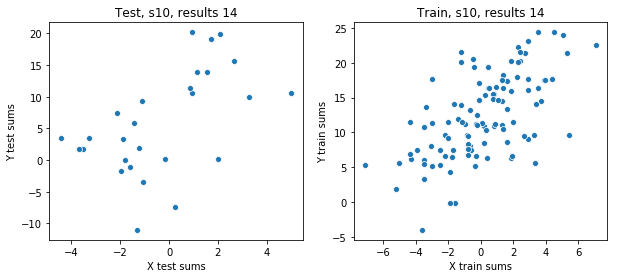

In [835]:
plot_weighted_sums('s10', results_14)

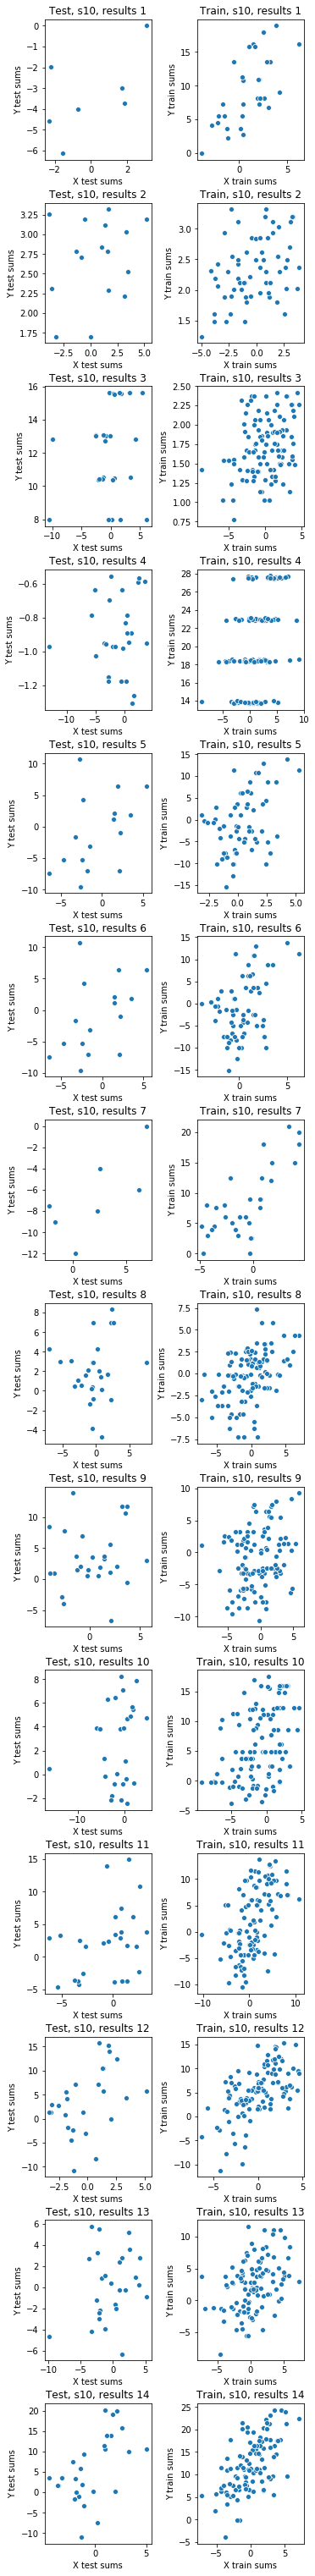

In [856]:
plot_weighted_sums('s10', all_results, 'weightedsums_s10_allres')

In [857]:
def plot_experiment_results(results, plot_title=None):
    
    fig, axes = plt.subplots(len(results), 2, figsize=(10, 6 * len(results)))
    fig.tight_layout(pad=3.0, w_pad=3.0, h_pad=10.0)  # to make room for titles and feature names
    axes = axes.flatten()
    y_feature_axes = []
    for i in range(len(results)):
        y_features = results[i]["Y_features"]
        y_feature_scores = np.repeat(0.0, len(y_features))
        mean_test_corrs = []
        mean_train_corrs = []
        
        for s in SUBJECTS:
            # 1. calculate the mean test and train correlations
            mean_test_corr = round(np.array(results[i][s]["cross_val"]["test_corrs"]).mean(), 3)
            mean_train_corr = round(np.array(results[i][s]["cross_val"]["train_corrs"]).mean(), 3)
            mean_test_corrs.append(mean_test_corr)
            mean_train_corrs.append(mean_train_corr)
            
            # should also calculate std? std = round(np.array(results[s]["cross_val"][type_ + "_corrs"]).std(), 3)
        
            # 2. calculate mean coefs for Y features
            mean_y = np.array(results[i][s]["cross_val"]["y_weights"]).mean(axis=0)
            for j in range(len(y_features)):
                y_feature_scores[j] += mean_y[j]
        
        for j in range(len(y_features)):
            y_feature_scores[j] /= len(SUBJECTS)
        
        # First plot
        data1 = pd.DataFrame({"subject": SUBJECTS + SUBJECTS, "corr": mean_test_corrs + mean_train_corrs, 
                             "type": np.append(np.repeat("test", len(SUBJECTS)), np.repeat("train", len(SUBJECTS)))})
        sns.pointplot(x="subject", y="corr", hue="type", data=data1, dodge=True, ax=axes[i * 2]).set(
            title="Test and train corrs, results %d" % results[i]["nr"])
        
        # Second plot
        data2 = pd.DataFrame({"feature": y_features, "coef": y_feature_scores})
        sns.pointplot(x="feature", y="coef", data=data2, dodge=True, ax=axes[i * 2 + 1]).set(
            title="Top Y features, results %d" % results[i]["nr"], xlabel="") # no xlabel, won't fit
        
        y_feature_axes.append(axes[i * 2 + 1])
    
    fix_labels(y_feature_axes, angle=90)  # only rotate the y feature names
    
    if plot_title != None:
        fig.savefig(plot_title + ".png", bbox_inches='tight')

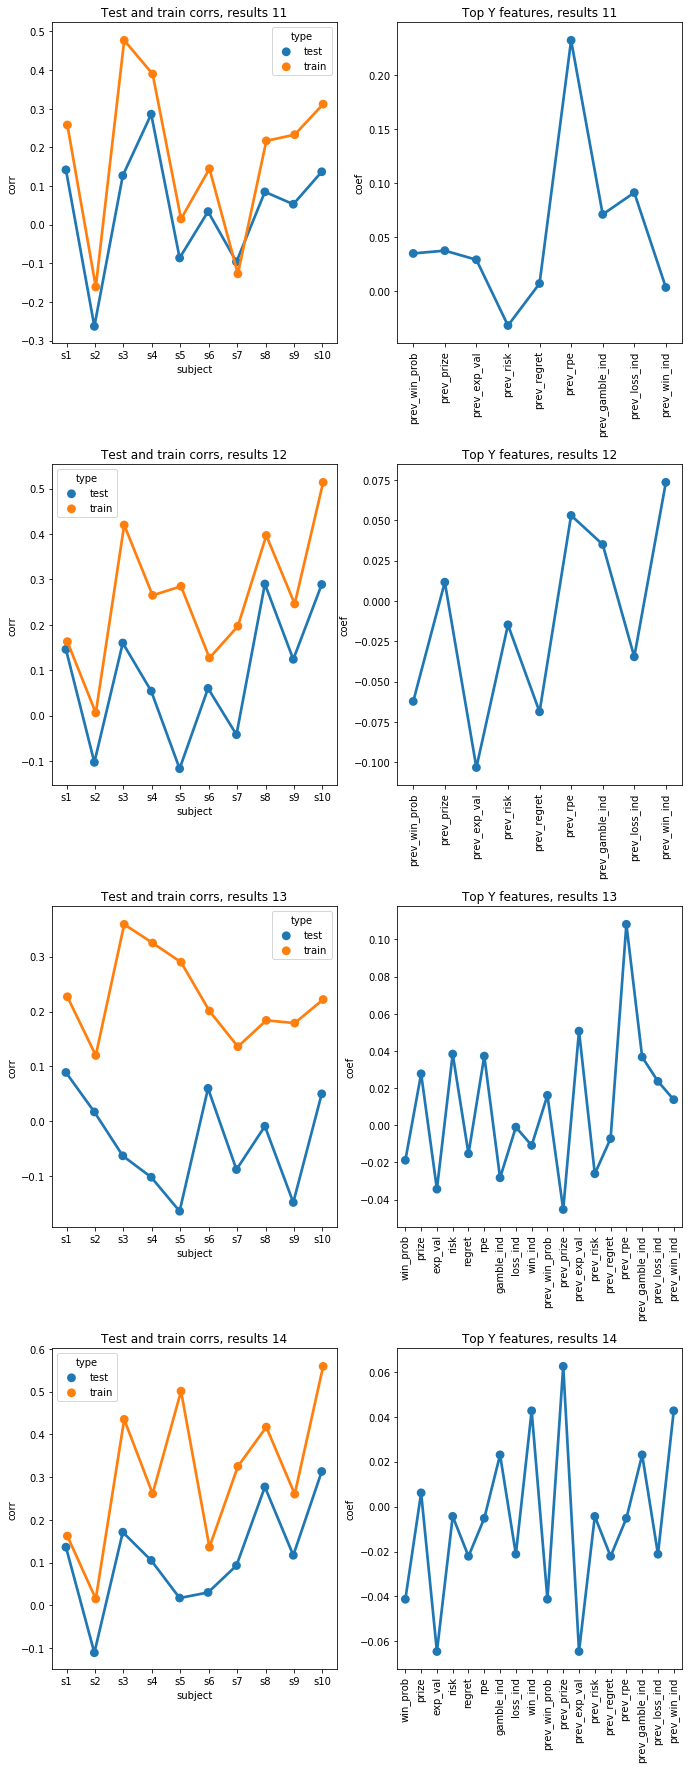

In [858]:
plot_experiment_results([results_11, results_12, results_13, results_14], "exp_res11-14")

In [859]:
def plot_patient_results(s, results, plot_title=None):
    # 1. Y features with mean coefs
    # 2. electrodes with mean coefs
    
    fig, axes = plt.subplots(len(results), 2, figsize=(10, 6 * len(results)))
    fig.tight_layout(pad=3.0, w_pad=3.0, h_pad=10.0)  # to make room for titles and feature names
    axes = axes.flatten()
    
    for i in range(len(results)):
        res = results[i]
        
        mean_X_coefs = np.array(res[s]["cross_val"]["x_weights"]).mean(axis=0)
        mean_Y_coefs = np.array(res[s]["cross_val"]["y_weights"]).mean(axis=0)
        
        # First plot
        data1 = pd.DataFrame({"elec": ["elec" + str(j) for j in range(1, N_ELEC[s] + 1)], 
                              "coef": mean_X_coefs})
        sns.pointplot(x="elec", y="coef", data=data1, dodge=True, ax=axes[i * 2]).set(
            title="Mean electrode coefs, results %d" % res["nr"], xlabel="")
        
        # Second plot
        data2 = pd.DataFrame({"feature": res["Y_features"], "coef": mean_Y_coefs})
        sns.pointplot(x="feature", y="coef", data=data2, dodge=True, ax=axes[i * 2 + 1]).set(
            title="Mean regressor coefs, results %d" % res["nr"], xlabel="")
    
    fix_labels(axes)
    if plot_title != None:
        fig.savefig(plot_title + ".png", bbox_inches='tight')        


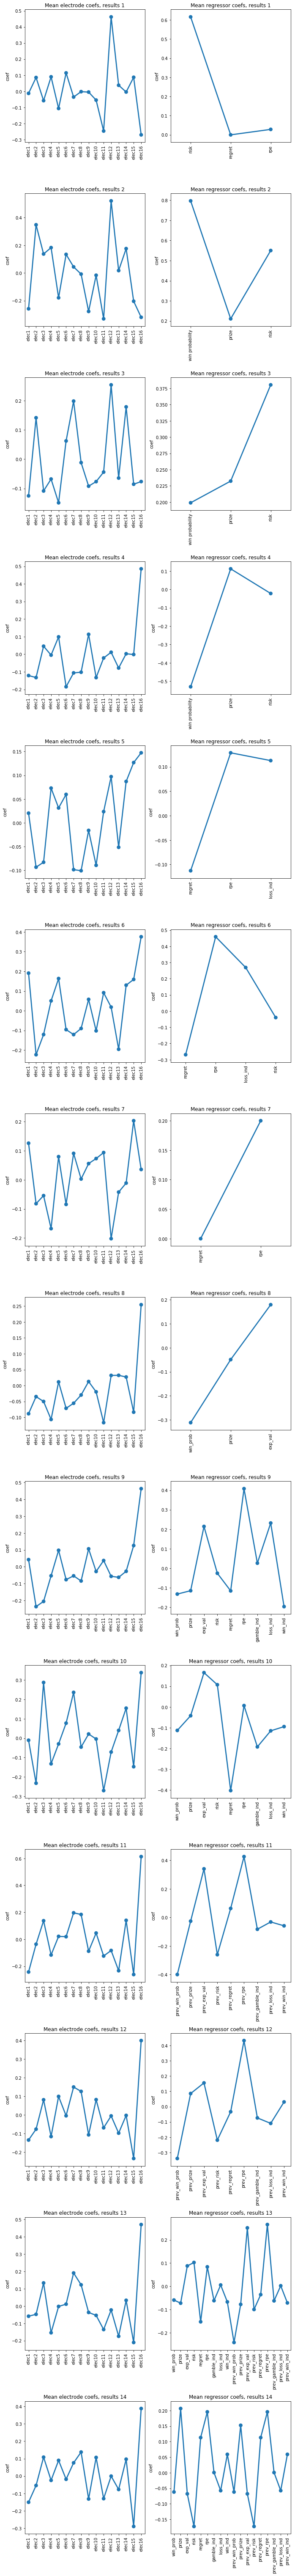

In [860]:
plot_patient_results('s10', all_results, "patient10_allres")

In [837]:
def plot_general_corr_results(results=all_results, subjects=SUBJECTS):
    avg_res_test_corrs = np.repeat(0.0, len(results))
    avg_res_train_corrs = np.repeat(0.0, len(results))
    avg_s_test_corrs = np.repeat(0.0, len(subjects))
    avg_s_train_corrs = np.repeat(0.0, len(subjects))
    
    for i in range(len(results)):
        res = all_results[i]
        
        for j in range(len(subjects)):
            s = subjects[j]
            avg_test_corr = np.array(res[s]["cross_val"]["test_corrs"]).mean()
            avg_train_corr = np.array(res[s]["cross_val"]["train_corrs"]).mean()
            
            avg_res_test_corrs[i] += avg_test_corr
            avg_res_train_corrs[i] += avg_train_corr
            
            avg_s_test_corrs[j] += avg_test_corr
            avg_s_train_corrs[j] += avg_train_corr
    
    avg_res_test_corrs /= len(results)
    avg_res_train_corrs /= len(results)
    avg_s_test_corrs /= len(results)
    avg_s_train_corrs /= len(results)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    axes = axes.flatten()
    
    # First plot
    data1 = pd.DataFrame({"subject": subjects + subjects, "corr": np.append(avg_s_test_corrs, avg_s_train_corrs), 
                         "type": np.append(np.repeat("test", len(subjects)), np.repeat("train", len(subjects)))})
    sns.pointplot(x="subject", y="corr", hue="type", data=data1, dodge=True, ax=axes[0]).set(
        title="Avg test and train corr per subject")

    # Second plot
    res_labels = ["res" + str(i) for i in range(1, len(results) + 1)]
    data2 = pd.DataFrame({"result": res_labels + res_labels, "corr": np.append(avg_res_test_corrs, avg_res_train_corrs),
                         "type": np.append(np.repeat("test", len(results)), np.repeat("train", len(results)))})
    sns.pointplot(x="result", y="corr", hue="type", data=data2, dodge=True, ax=axes[1]).set(
        title="Avg test and train corr per result")

    fix_labels(axes)
    
    fig.savefig("avg_corrs_general.png")

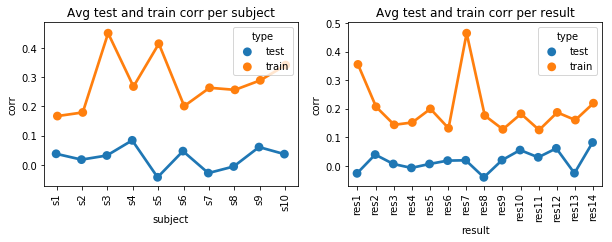

In [838]:
plot_general_corr_results()

In [845]:
def plot_regressor_results(results=all_results, subjects=SUBJECTS):
    # Y features with mean coefs
    # (top) Y features with mean coefs for
        # (a) results where time period between game presentation and buttonpress
        # (b) results where time period after outcome reveal
    cases_a = [2, 3, 4, 8, 9, 11, 13]  # the numbers of the results which are of case a
    cases_b = [1, 5, 6, 7, 10, 12, 14]  # the numbers of the results which are of case b
    y_features_counts = defaultdict(list)  # counts in how many results the feature is
    y_features_coefs = defaultdict(float)  # the (mean) coeficients
    coefs_counts = defaultdict(lambda: defaultdict(int))
    # for every feature: "mean_a" (float), "mean_b" (float), "cases_a" (int), "cases_b" (int)
    
    for result in results:
        y_features = result["Y_features"]
        res_nr = result["nr"]
        case = "cases_a" if res_nr in cases_a else "cases_b"
        case_mn = "mean_a" if res_nr in cases_a else "mean_b"
        
        # Increase the counts
        for f in y_features:
            coefs_counts[f][case] += 1
            
        for s in subjects:
            mean_Y_coefs = np.array(result[s]["cross_val"]["y_weights"]).mean(axis=0)
            
            # for every feature in this result, add to the corresponding mean sum
            for j in range(len(y_features)):
                coefs_counts[y_features[j]][case_mn] += mean_Y_coefs[j]
    
    for f in coefs_counts:
        cases = coefs_counts[f]["cases_a"] + coefs_counts[f]["cases_b"]
        # divide by the number of results the feature appeared in
        coefs_counts[f]["mean"] = (coefs_counts[f]["mean_a"] + coefs_counts[f]["mean_b"]) / (cases * len(subjects))
        if coefs_counts[f]["cases_a"] > 0:
            coefs_counts[f]["mean_a"] /= coefs_counts[f]["cases_a"] * len(subjects)
        if coefs_counts[f]["cases_b"] > 0:
            coefs_counts[f]["mean_b"] /= coefs_counts[f]["cases_b"] * len(subjects)

    data = pd.DataFrame.from_dict(coefs_counts).transpose()  # cases_a, cases_b, mean, mean_a, mean_b are the columns
    # regressors are the indices
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 3))
    plt.tight_layout()
    axes = axes.flatten()
    
    # First plot
    data1 = pd.DataFrame({"regressor": data.index, "coef": data["mean"]}).sort_values(by="coef")
    sns.pointplot(x="regressor", y="coef", data=data1, dodge=True, ax=axes[0]).set(
        title="Mean regressor coefs", xlabel="")

    # Second plot
    data2 = pd.DataFrame({"regressor": data[data["cases_a"] != 0].index, "coef": data[data["cases_a"] != 0]["mean_a"]}).sort_values(by="coef")
    sns.pointplot(x="regressor", y="coef", data=data2, dodge=True, ax=axes[1]).set(
        title="Mean regressor coefs for case A", xlabel="", ylabel="")  # only need the leftmost y label 

        # Second plot
    data3 = pd.DataFrame({"regressor": data[data["cases_b"] != 0].index, "coef": data[data["cases_b"] != 0]["mean_b"]}).sort_values(by="coef")
    sns.pointplot(x="regressor", y="coef", data=data3, dodge=True, ax=axes[2]).set(
        title="Mean regressor coefs for case B", xlabel="", ylabel="")  # only need the leftmost y label 
    
    fix_labels(axes)
    fig.savefig("mean_regressor_coefs.png", bbox_inches='tight')


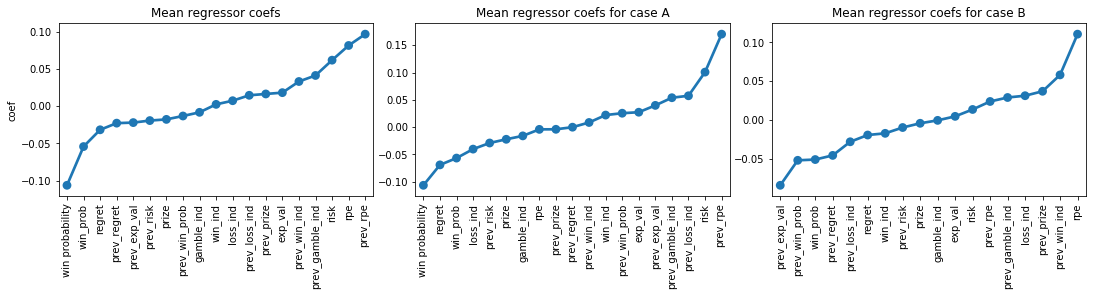

In [846]:
plot_regressor_results()

In [687]:
def similarities_subject(subjects=SUBJECTS, results=all_results):
    n_s = len(subjects)
    n_r = len(results)
    similarities_elec = {}
    similarities_Y = {}
        
    for s in subjects:
        elecs = np.array(["elec" + str(i) for i in range(1, N_ELEC[s] + 1)])
        similarities_elec[s] = np.ones((n_r, n_r))
        similarities_Y[s] = np.ones((n_r, n_r))
        
        # For every result: sort the electrodes by mean coef -> elec_sorted_1; sort regressors by mean coef -> Y_sorted_1
        #     For every other result: sort elecs by mn coef -> elec_sorted_2; sort regrs by mn coef -> Y_sorted_2
        #     Then compare with ratio: (1) elec_sorted_1 and elec_sorted_2 (2) and Y_sorted_1 and Y_sorted_2
        for i in range(n_r):
            res_1 = results[i]
            y_features_1 = np.array(res_1["Y_features"])
            mean_X_coefs_1 = np.array(res_1[s]["cross_val"]["x_weights"]).mean(axis=0)
            mean_Y_coefs_1 = np.array(res_1[s]["cross_val"]["y_weights"]).mean(axis=0)
            sorted_X_idx_1 = np.argsort(mean_X_coefs_1)[::-1] # reverse argsort
            sorted_Y_idx_1 = np.argsort(mean_Y_coefs_1)[::-1] # reverse argsort
            elec_sorted_1 = elecs[sorted_X_idx_1] # sort electrodes by mean coef
            Y_sorted_1 = y_features_1[sorted_Y_idx_1] # sort regressors
            
            for j in range(i + 1, n_r):
                res_2 = results[j]
                y_features_2 = np.array(res_2["Y_features"])
                mean_X_coefs_2 = np.array(res_2[s]["cross_val"]["x_weights"]).mean(axis=0)
                mean_Y_coefs_2 = np.array(res_2[s]["cross_val"]["y_weights"]).mean(axis=0)
                sorted_X_idx_2 = np.argsort(mean_X_coefs_2)[::-1] # reverse argsort
                sorted_Y_idx_2 = np.argsort(mean_Y_coefs_2)[::-1] # reverse argsort
                elec_sorted_2 = elecs[sorted_X_idx_2] # sort electrodes by mean coef
                Y_sorted_2 = y_features_2[sorted_Y_idx_2] # sort regressors
                
                sm_elec = SequenceMatcher(None, elec_sorted_1, elec_sorted_2)
                similarities_elec[s][i][j] = round(sm_elec.ratio(), 2)
                
                sm_Y = SequenceMatcher(None, Y_sorted_1, Y_sorted_2)
                similarities_Y[s][i][j] = round(sm_Y.ratio(), 2)
            
            similarities_elec[s][:, i] = similarities_elec[s][i, :]
            similarities_Y[s][:, i] = similarities_Y[s][i, :]

        
        labels = ["res" + str(i) for i in range(1, n_r + 1)]
        data_elec = pd.DataFrame(similarities_elec[s], columns=labels, index=labels)
        data_Y = pd.DataFrame(similarities_Y[s], columns=labels, index=labels)
        similarities_elec[s] = data_elec
        similarities_Y[s] = data_Y
        
    return similarities_elec, similarities_Y

In [678]:
similarities_elec, similarities_Y = similarities_subject()

In [847]:
def plot_similarities(sim_elec, sim_Y, subjects=SUBJECTS, results=all_results):
    n_res = len(results)
    n_sub = len(subjects)
    labels = ["res" + str(i) for i in range(1, n_res + 1)]
    fig, axes = plt.subplots(n_sub, 2, figsize=(16, 6 * n_sub))
    axes = axes.flatten()
    
    for i in range(n_sub):
        s = subjects[i]
        sim_elec_s = sim_elec[s]
        sim_Y_s = sim_Y[s]
    
        # First plot
        sns.heatmap(sim_elec_s, annot=True, annot_kws={"size":10}, fmt='g', xticklabels=labels, yticklabels=labels, 
                    ax=axes[i * 2]).set(title="Subject %s, electrode similarities" % s)
        
        # Second plot
        sns.heatmap(sim_Y_s, annot=True, annot_kws={"size":10}, fmt='g', xticklabels=labels, yticklabels=labels, 
                    ax=axes[i * 2 + 1]).set(title="Subject %s, regressor similarities" % s)

    fix_labels(axes)
    fig.savefig("similarities_per_subject.png", bbox_inches='tight')

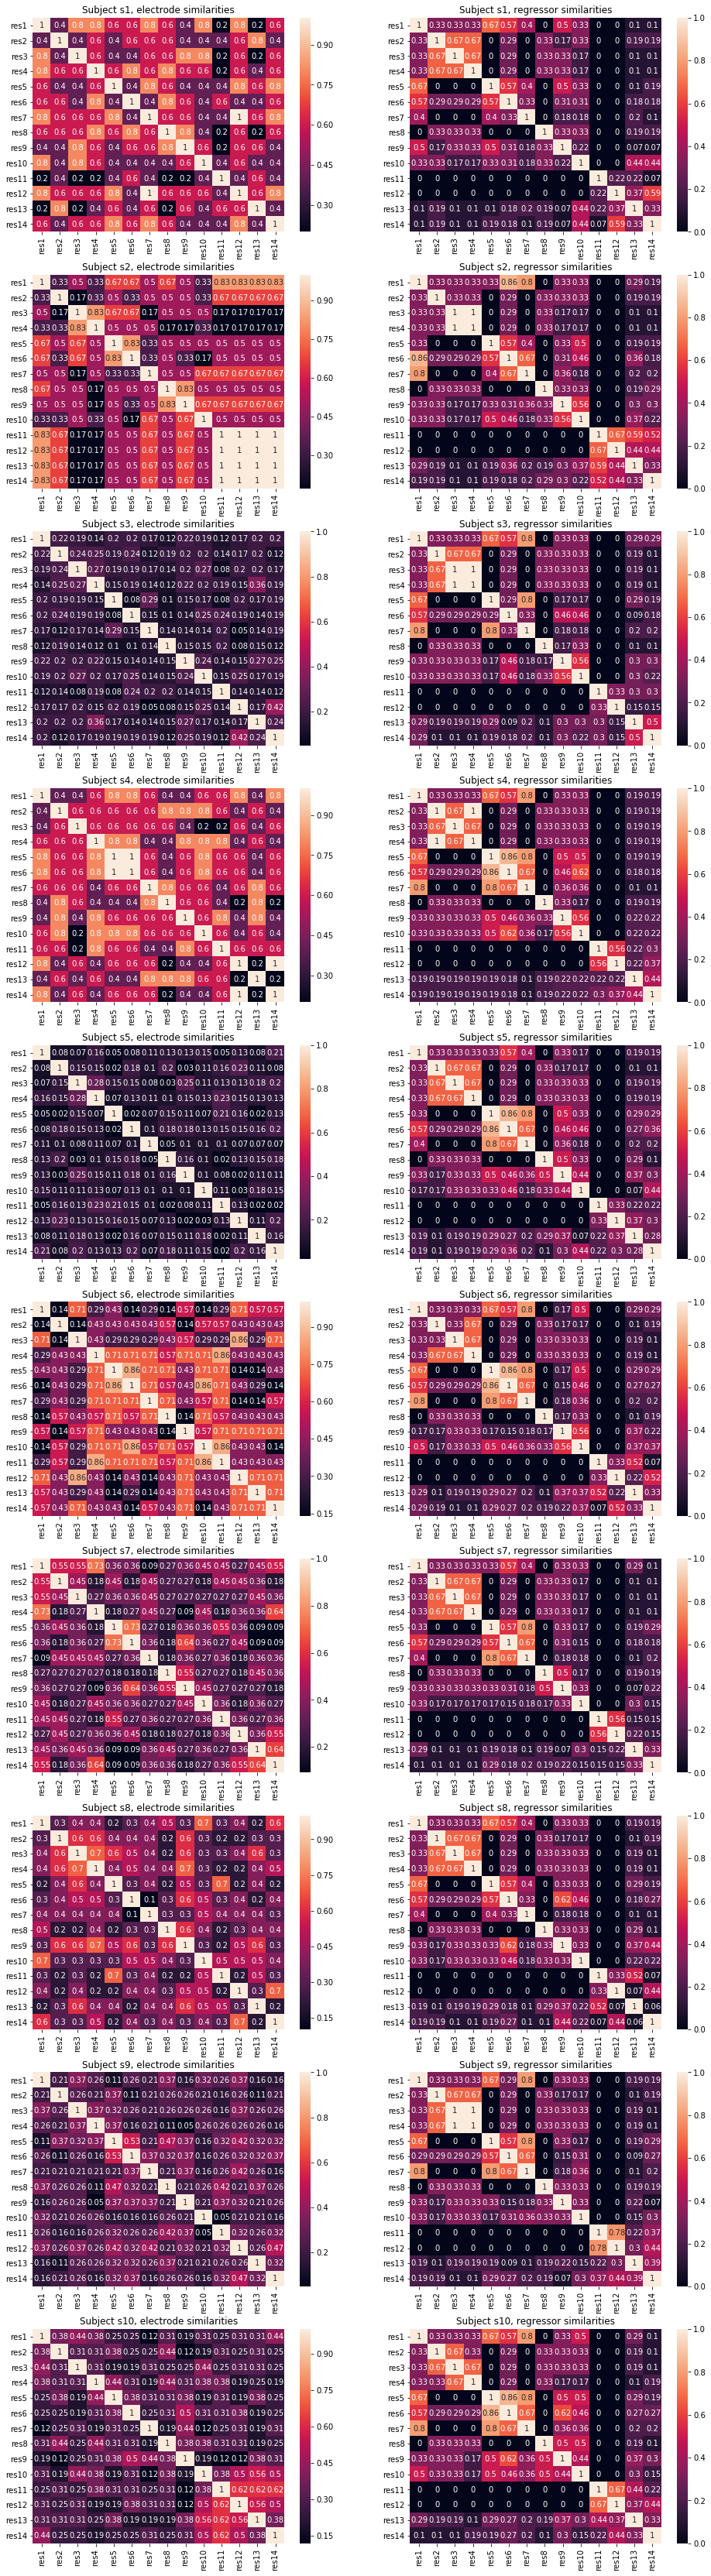

In [848]:
plot_similarities(similarities_elec, similarities_Y)

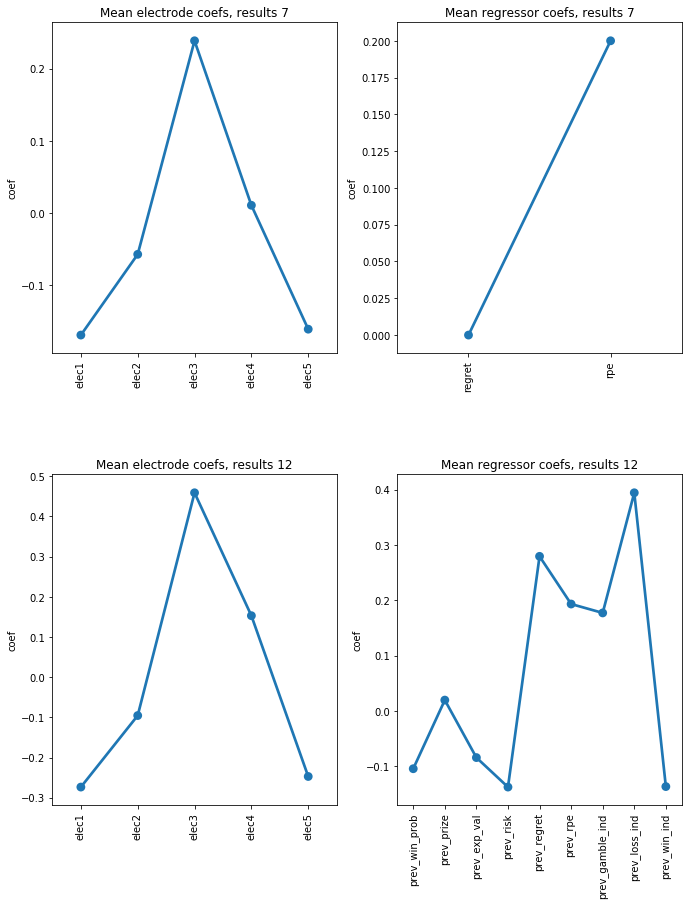

In [819]:
plot_patient_results('s1', [results_7, results_12])

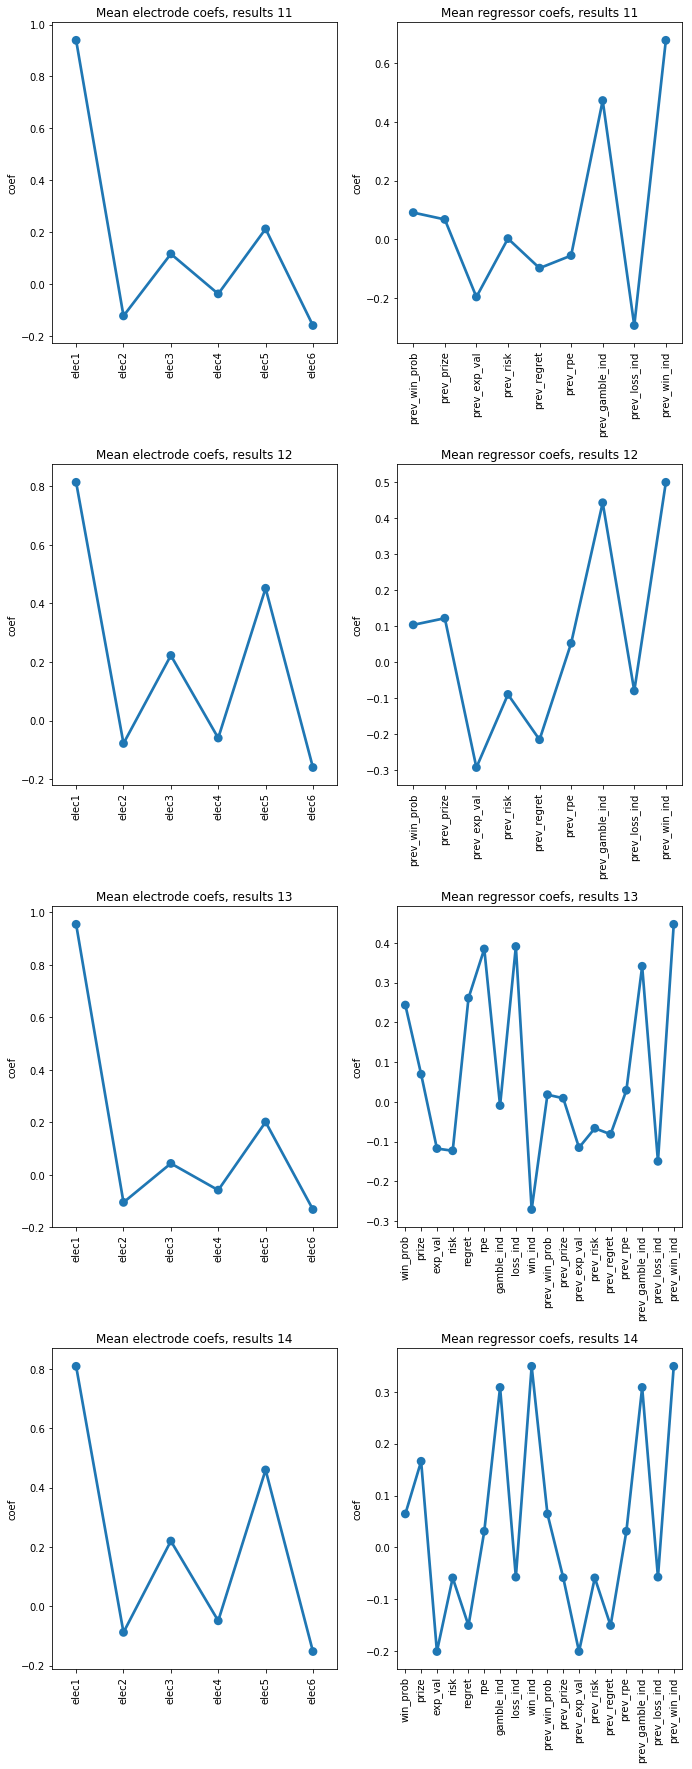

In [820]:
plot_patient_results('s2', [results_11, results_12, results_13, results_14])

In [728]:
def similarities_result(subjects=SUBJECTS, results=all_results):
    n_s = len(subjects)
    n_r = len(results)
    similarities_Y = {}
    
        
    for res in results:
        y_features = np.array(res["Y_features"])
        res_nr = res["nr"]
        similarities_Y[res_nr] = np.ones((n_s, n_s))
        
        for i in range(n_s):
            s_1 = subjects[i]
            mean_Y_coefs_1 = np.array(res[s_1]["cross_val"]["y_weights"]).mean(axis=0)
            sorted_Y_idx_1 = np.argsort(mean_Y_coefs_1)[::-1] # reverse argsort
            Y_sorted_1 = y_features[sorted_Y_idx_1] # sort regressors
            
            for j in range(i + 1, n_s):
                s_2 = subjects[j]
                mean_Y_coefs_2 = np.array(res[s_2]["cross_val"]["y_weights"]).mean(axis=0)
                sorted_Y_idx_2 = np.argsort(mean_Y_coefs_2)[::-1] # reverse argsort
                Y_sorted_2 = y_features[sorted_Y_idx_2] # sort regressors
                
                sm = SequenceMatcher(None, Y_sorted_1, Y_sorted_2)
                similarities_Y[res_nr][i][j] = round(sm.ratio(), 2)
            
            similarities_Y[res_nr][:, i] = similarities_Y[res_nr][i, :]

        
        labels = ["s" + str(i) for i in range(1, n_s + 1)]
        data_Y = pd.DataFrame(similarities_Y[res_nr], columns=labels, index=labels)
        similarities_Y[res_nr] = data_Y
        
    return similarities_Y

In [702]:
similarities_res_Y = similarities_result()
similarities_res_Y[1]

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10
s1,1.00,0.33,0.67,0.67,1.00,0.33,0.33,0.67,0.67,0.67
s2,0.33,1.00,0.67,0.67,0.33,1.00,1.00,0.67,0.67,0.67
s3,0.67,0.67,1.00,1.00,0.67,0.67,0.67,0.33,1.00,1.00
s4,0.67,0.67,1.00,1.00,0.67,0.67,0.67,0.33,1.00,1.00
s5,1.00,0.33,0.67,0.67,1.00,0.33,0.33,0.67,0.67,0.67
s6,0.33,1.00,0.67,0.67,0.33,1.00,1.00,0.67,0.67,0.67
s7,0.33,1.00,0.67,0.67,0.33,1.00,1.00,0.67,0.67,0.67
s8,0.67,0.67,0.33,0.33,0.67,0.67,0.67,1.00,0.33,0.33
s9,0.67,0.67,1.00,1.00,0.67,0.67,0.67,0.33,1.00,1.00
s10,0.67,0.67,1.00,1.00,0.67,0.67,0.67,0.33,1.00,1.00


In [851]:
def plot_similarities_res(sim_Y, subjects=SUBJECTS, results=all_results):
    n_res = len(results)
    n_sub = len(subjects)
    labels = ["s" + str(i) for i in range(1, n_sub + 1)]
    fig, axes = plt.subplots(int(n_res / 2), 2, figsize=(16, 6 * int(n_res / 2)))
    axes = axes.flatten()
    
    for i in range(n_res):
        res_nr = results[i]["nr"]
        sim_Y_s = sim_Y[res_nr]
    
        sns.heatmap(sim_Y_s, annot=True, annot_kws={"size":10}, fmt='g', xticklabels=labels, yticklabels=labels, 
                    ax=axes[i]).set(title="Result %d, regressor similarities" % res_nr)

    fix_labels(axes)
    fig.savefig("similarities_per_result.png", bbox_inches='tight')    


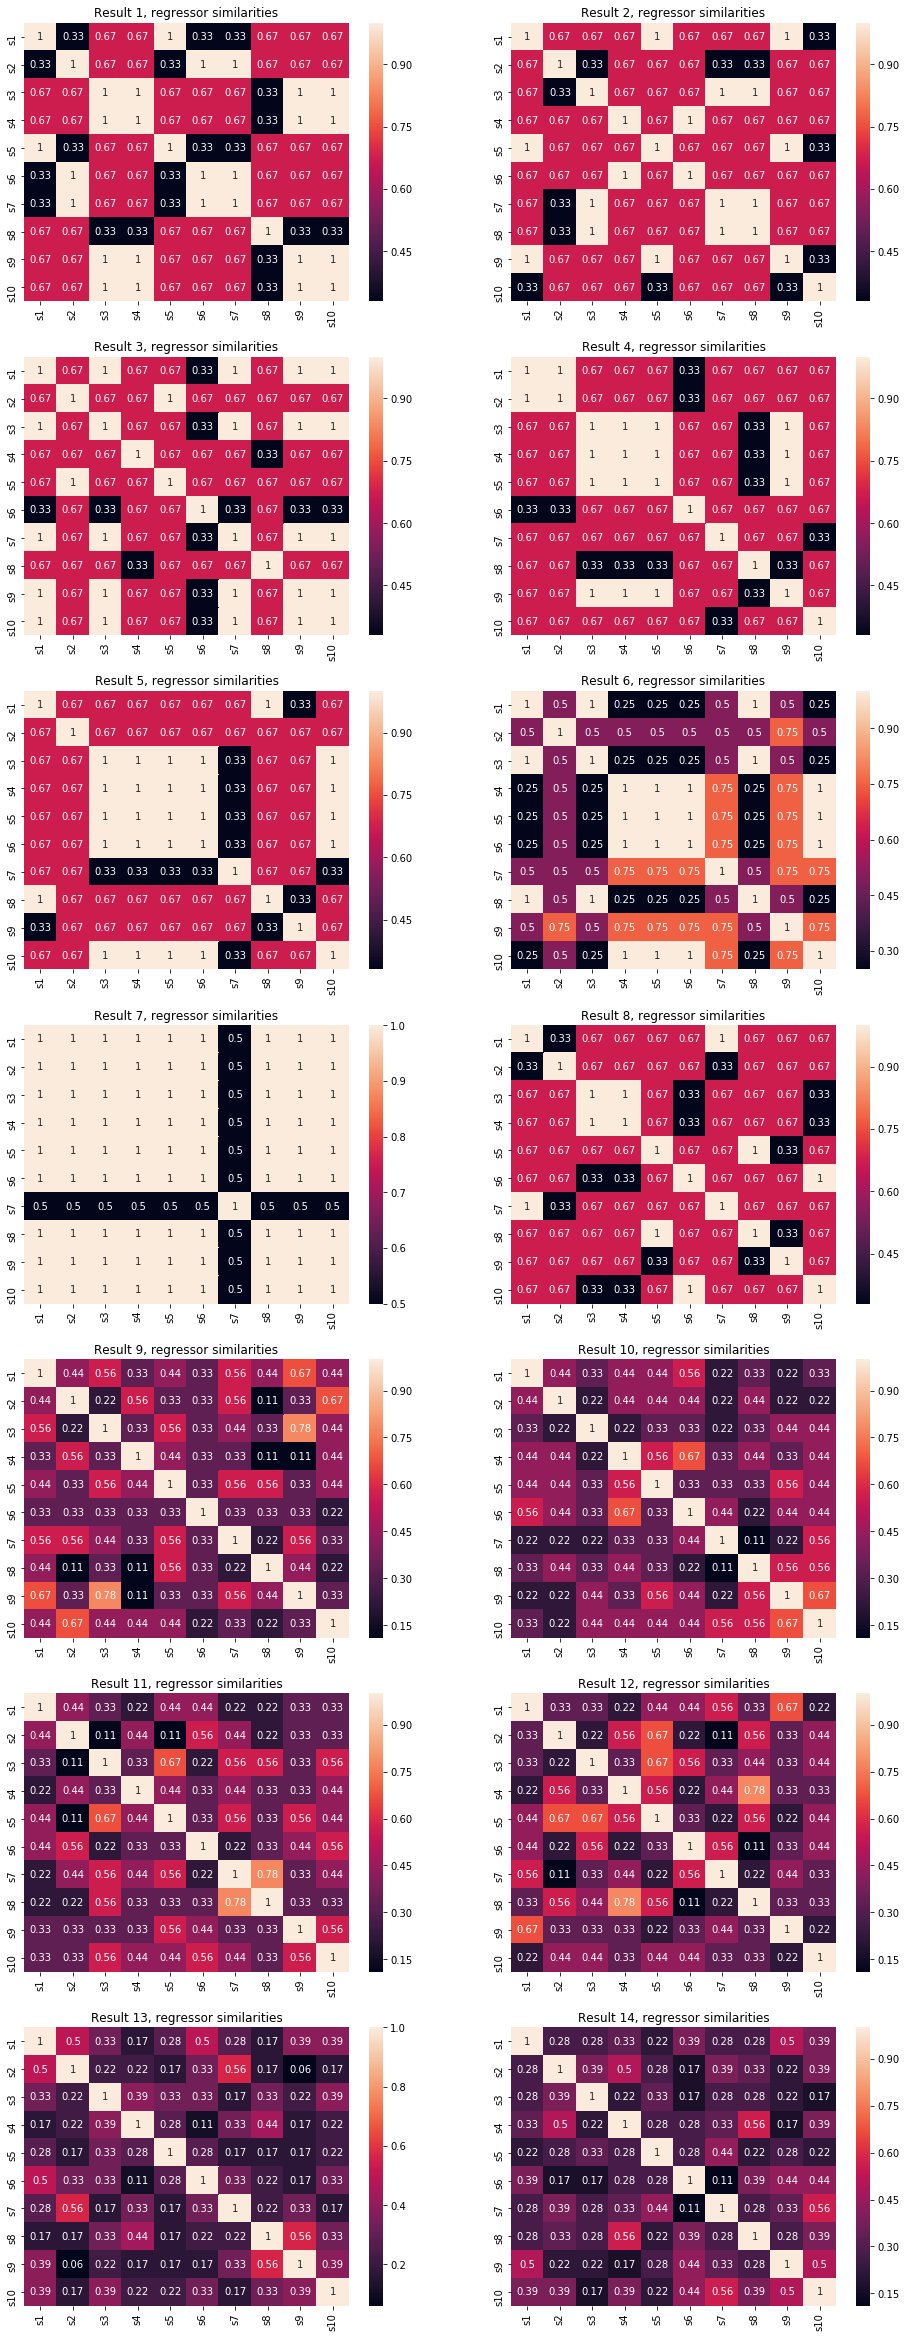

In [852]:
plot_similarities_res(similarities_res_Y)

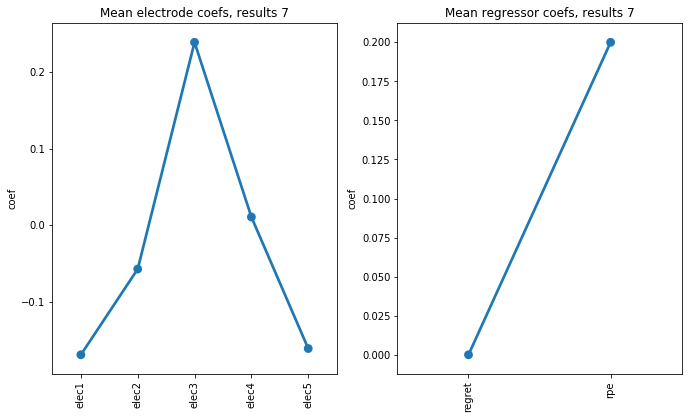

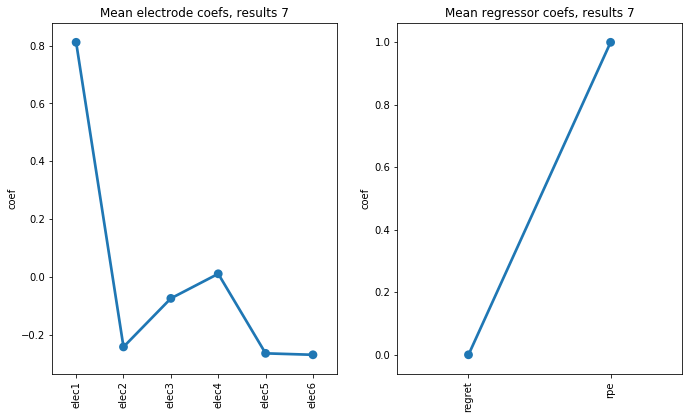

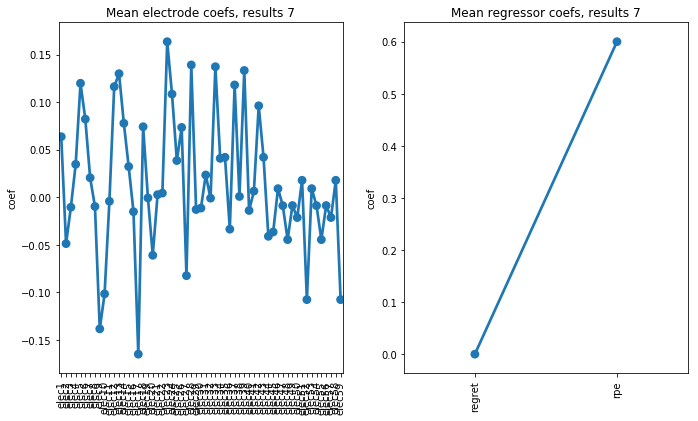

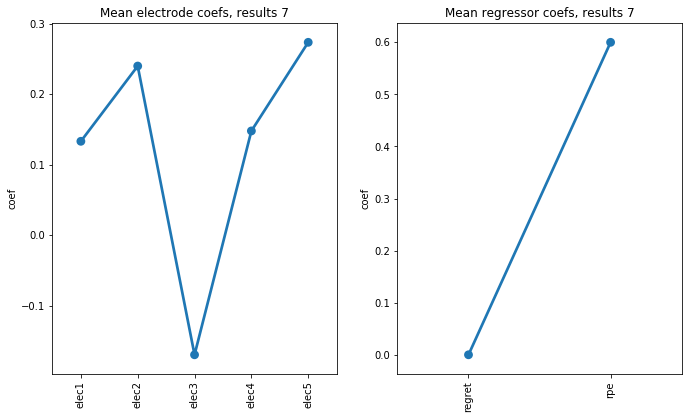

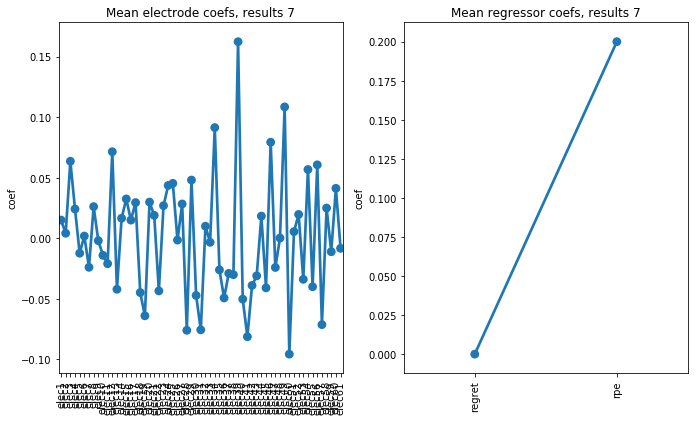

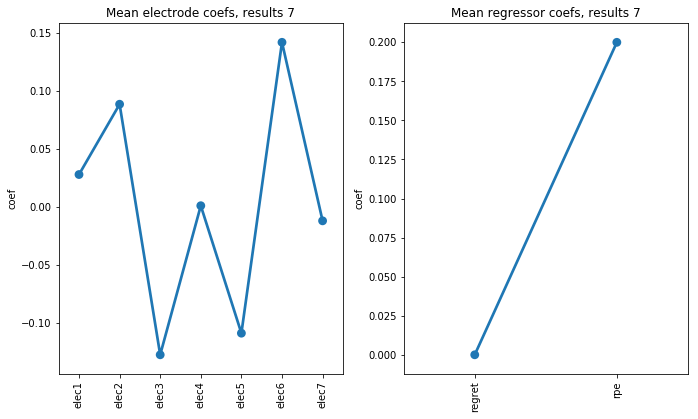

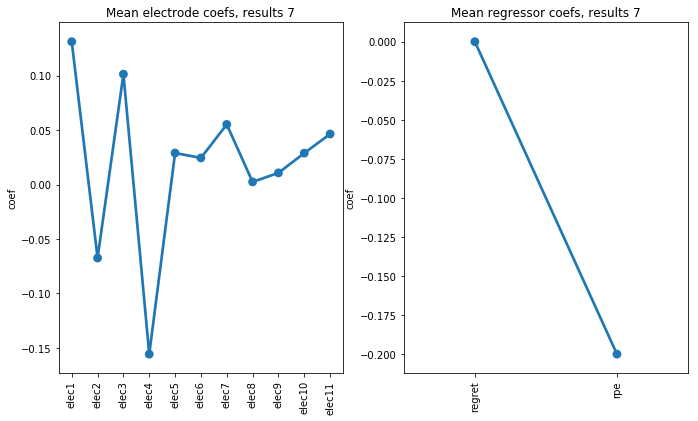

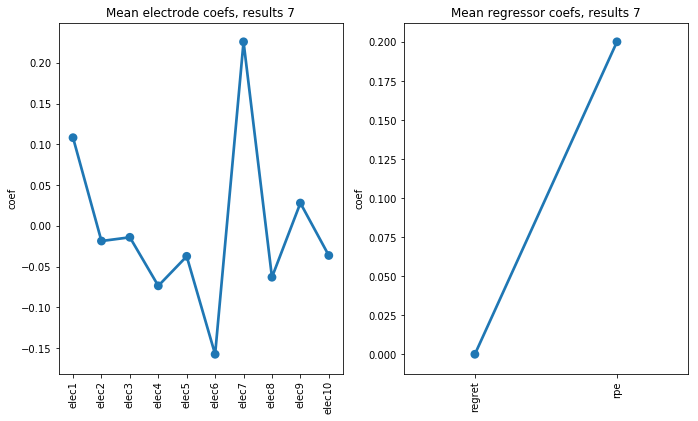

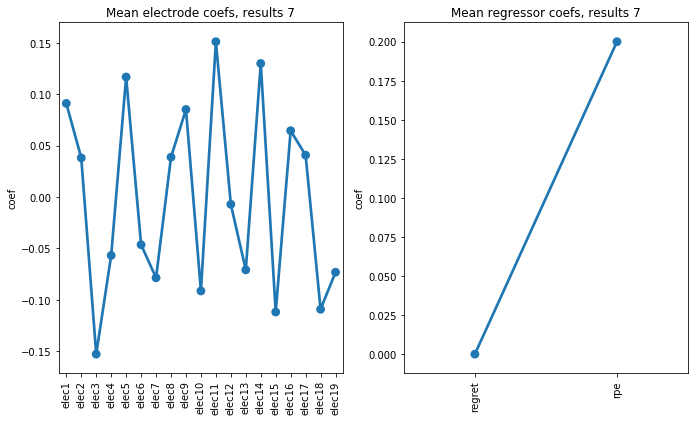

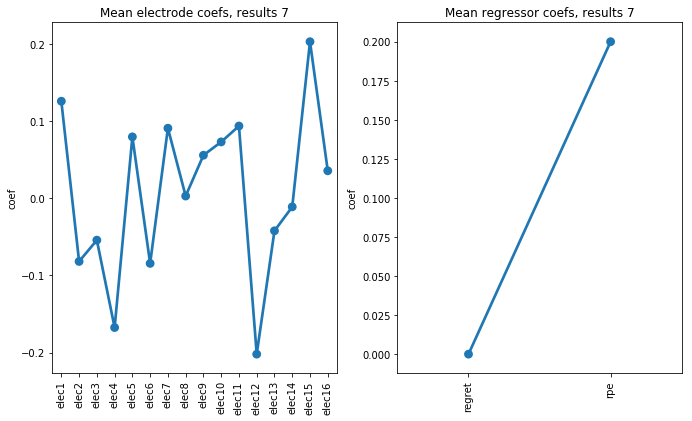

In [821]:
for s in SUBJECTS:
    plot_patient_results(s, [results_7])